# CIFAR10 image classification CNN optimization

In this project, I aim to systematically optimize a neural network classifier for this dataset, exploring both architectural modifications and the benefits of transfer learning.

## The CIFAR-10 dataset:

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.The CIFAR-10 dataset

<img src="https://miro.medium.com/max/709/1*LyV7_xga4jUHdx4_jHk1PQ.png" width="400" height="300" alt="cifar10">

Initially, I focused on refining the model architecture itself. I`ve created the CIFAR10ModelTester class to streamline the evaluation process.

The goal in this phase is to determine the highest achievable test accuracy through iterative improvements to the architecture and hyperparameter tuning alone.

- Dropout & Normalization: Added dropout layers for regularization, batch normalization for stability.
- Increased Complexity: Gradually added convolutional layers, experimented with filter sizes.
- Callbacks: Implemented early stopping, model checkpointing, and learning rate scheduling.
- Hyperparameter Tuning: Tested batch sizes, optimized learning rate, weight decay.
- Regularization: Applied weight decay, utilized learning rate schedules.
- Global Average Pooling: Replaced fully connected layers to reduce overfitting.

#### **Best test accuracy (arch and hyperparam tunning)**
***0.894 (Model 7).***

In the end, I explored the potential of transfer learning.

I experimented with **Xception and EfficientNetB2** from Keras, as well as **ResNet34** from FastAI.

By fine-tuning these models on the CIFAR-10 dataset, I further boosted classification accuracy.

#### **Best final test accuracy:**
***0.9706 using ResNet34.***


In [ ]:
"""
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/NUCLIO_drive/Entregables/cifar10_cnn_optimization/'
"""

Mounted at /content/drive


In [2]:
from tensorflow import keras as ks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import time
import datetime

#suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Define "CIFAR10ModelTester" class

By automating the training, evaluation, and visualization process, it allows for efficient comparison of various models.

In [ ]:
class CIFAR10ModelTester:
    def __init__(self, x_train=None, y_train=None, x_val=None, y_val=None, x_test=None, y_test=None,
                 train_generator=None, val_generator=None, test_generator=None):
        self.x_train = x_train
        self.y_train = y_train
        self.x_val = x_val
        self.y_val = y_val
        self.x_test = x_test
        self.y_test = y_test
        self.train_generator = train_generator
        self.val_generator = val_generator
        self.test_generator = test_generator

    def test_model(self, model, model_nr, epochs=10, batch_size=512, optimizer='adam',
                   loss='sparse_categorical_crossentropy', transfer_learning=False,
                   dropout=False, batch_normalization=False, early_stopping=False,
                   steps_per_epoch=None, validation_steps=None, callbacks=None):

        model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

        t_start = time.perf_counter()

        if self.train_generator and self.val_generator:
          history = model.fit(
              self.train_generator,
              steps_per_epoch=steps_per_epoch,
              epochs=epochs,
              validation_data=self.val_generator,
              validation_steps=validation_steps,
              callbacks=callbacks
          )
        else:
          history = model.fit(
              self.x_train, self.y_train,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(self.x_val, self.y_val),
              callbacks=callbacks
          )

        elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t_start))

        if self.train_generator and self.val_generator:
            train_loss, train_acc = model.evaluate(self.train_generator, verbose=0)
        else:
            train_loss, train_acc = model.evaluate(self.x_train, self.y_train, verbose=0)

        if self.test_generator:
            test_loss, test_acc = model.evaluate(self.test_generator, verbose=0)
        else:
            test_loss, test_acc = model.evaluate(self.x_test, self.y_test, verbose=0)

        self._plot_history(history, save_path=path+f'model_{model_nr}_history.png')
        self._plot_predictions(model)

        print('\n', 'Training time:', elapsed_time)
        print('\n', f'Train accuracy: {train_acc:.3f}')
        print('\n', f'Test accuracy: {test_acc:.3f}')

        model_info = self._get_model_info(model, model_nr, history, train_acc, test_acc, elapsed_time,
                                          batch_size, optimizer, loss, transfer_learning,
                                          dropout, batch_normalization, early_stopping)

        return model, history, model_info

    def _plot_history(self, history, save_path):
        plt.figure(figsize=(12, 5))
        plt.clf()  # Clear the current figure

        plt.subplot(1, 2, 1)
        plt.title('Cross Entropy Loss')
        plt.plot(history.history['loss'], color='blue', label='train')
        plt.plot(history.history['val_loss'], color='orange', label='val')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.title('Classification Accuracy')
        plt.plot(history.history['accuracy'], color='blue', label='train')
        plt.plot(history.history['val_accuracy'], color='orange', label='val')
        plt.legend()

        plt.tight_layout()
        plt.savefig(save_path)
        print(f"Training history plot saved to {save_path}")

        plt.show()  # Show the plot after saving
        plt.close()  # Close the figure to free up memory

    def _plot_predictions(self, model):
        if self.test_generator:
            x_test_batch, y_test_batch = next(self.test_generator)
        else:
            x_test_batch, y_test_batch = self.x_test, self.y_test

        predictions = model.predict(x_test_batch)
        num_rows, num_cols = 5, 4
        start = 0
        num_images = num_rows * num_cols
        plt.figure(figsize=(2*2*num_cols, 2*num_rows))
        for i in range(num_images):
            plt.subplot(num_rows, 2*num_cols, 2*i+1)
            self._plot_image(i+start, predictions[i+start], y_test_batch, x_test_batch)
            plt.subplot(num_rows, 2*num_cols, 2*i+2)
            self._plot_value_array(i+start, predictions[i+start], y_test_batch)
        plt.tight_layout()
        plt.show()

    def _plot_image(self, i, predictions_array, true_label, img):
        predictions_array, true_label, img = predictions_array, true_label[i], img[i]
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        if img.shape[-1] == 3 and np.max(img) <= 1:
            img = (img * 255).astype(np.uint8)
        plt.imshow(img, cmap=plt.cm.binary)
        predicted_label = np.argmax(predictions_array)
        color = 'blue' if predicted_label == true_label else 'red'
        plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                    100*np.max(predictions_array),
                                    true_label),
                                    color=color)

    def _plot_value_array(self, i, predictions_array, true_label):
        predictions_array, true_label = predictions_array, true_label[i]
        plt.grid(False)
        plt.xticks(range(10))
        plt.yticks([])
        thisplot = plt.bar(range(10), predictions_array, color="#777777")
        plt.ylim([0, 1])
        predicted_label = np.argmax(predictions_array)
        thisplot[predicted_label].set_color('red')
        thisplot[true_label].set_color('blue')

    def _get_model_info(self, model, model_nr, history, train_acc, test_acc, elapsed_time,
                        batch_size, optimizer, loss, transfer_learning,
                        dropout, batch_normalization, early_stopping):
        num_layers = len(model.layers)
        num_neurons = sum([layer.units for layer in model.layers if hasattr(layer, 'units')])
        total_params = model.count_params()
        actual_epochs = len(history.history['loss'])

        # Format elapsed time as text
        elapsed_time_seconds = elapsed_time.total_seconds()
        elapsed_time_str = str(datetime.timedelta(seconds=elapsed_time_seconds))

        # Round accuracy and loss values
        train_acc_rounded = round(train_acc, 3)
        test_acc_rounded = round(test_acc, 3)
        final_loss_rounded = round(history.history['loss'][-1], 3)

        return {
            'Model_nr': model_nr,
            'Train_Accuracy': train_acc_rounded,
            'Test_Accuracy': test_acc_rounded,
            'Final_Loss': final_loss_rounded,
            'Train_time': elapsed_time_str,
            'Num_Layers': num_layers,
            'Num_Neurons': num_neurons,
            'Total_Params': total_params,
            'Batch_Size': batch_size,
            'Optimizer': optimizer,
            'Loss_Function': loss,
            'Transfer_Learning': transfer_learning,
            'Dropout': dropout,
            'Batch_Normalization': batch_normalization,
            'Early_Stopping': early_stopping,
            'Num_Epochs': actual_epochs,
        }

# Data download and prep

170498071/170498071 [==============================] - 3s 0us/step
Number of labels: 10
Train: X=(50000, 32, 32, 3), y=(50000,)
Test: X=(10000, 32, 32, 3), y=(10000,)

 Sample images (Labelled): 



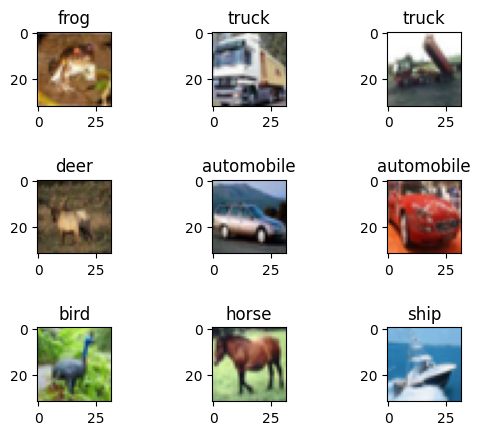


 Final train, test, and validation shapes: 

Train: X=(40000, 32, 32, 3), y=(40000,)
Test: X=(10000, 32, 32, 3), y=(10000,)
Validation: X=(10000, 32, 32, 3), y=(10000,)


In [ ]:
# Load CIFAR-10 data
cifar10 = ks.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1
x_train_scaled, x_test_scaled = x_train / 255.0, x_test / 255.0

# Flatten labels
y_train = y_train.ravel()
y_test = y_test.ravel()

# CIFAR-10 labels
cifar10_labels = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

print('Number of labels: %s' % len(cifar10_labels))

# Display sample images from CIFAR-10
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

# view a sample of labelled images
print('\n', 'Sample images (Labelled):', '\n')
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
    plt.title(cifar10_labels[y_train[i]])
plt.subplots_adjust(hspace=1)
plt.show()

# Split validation data from training data
x_val_scaled = x_train_scaled[-10000:]
y_val = y_train[-10000:]
x_train_scaled = x_train_scaled[:-10000]
y_train = y_train[:-10000:]

# Validate the shapes
print('\n', 'Final train, test, and validation shapes:', '\n')

print('Train: X=%s, y=%s' % (x_train_scaled.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test_scaled.shape, y_test.shape))
print('Validation: X=%s, y=%s' % (x_val_scaled.shape, y_val.shape))


## Creating dataframe for models comparison

In [ ]:
models_compare_df = pd.DataFrame()

In [ ]:
# load saved models_compare
#models_compare_df = pd.read_csv(path + "models_compare_df.csv", index_col=0)

# Network architecture optimization and hyperparameter tunning

## Model 0

Baseline Model: This model serves as our starting point to establish a baseline performance on the CIFAR-10 dataset.

### Model metrics:

**Test accuracy: 0.573**

In [ ]:
model_nr = 0

# Model arch
model = ks.Sequential()

model.add(ks.layers.Conv2D(32, (3, 3), strides=1, activation='relu', padding='same', input_shape=(32,32,3)))
model.add(ks.layers.MaxPooling2D((2, 2)))

model.add(ks.layers.Flatten())
model.add(ks.layers.Dense(32, activation='relu'))
model.add(ks.layers.Dense(10, activation='softmax'))

Epoch 1/30
79/79 [==============================] - 2s 18ms/step - loss: 2.1575 - accuracy: 0.2310 - val_loss: 2.0170 - val_accuracy: 0.2729
Epoch 2/30
79/79 [==============================] - 1s 11ms/step - loss: 1.8677 - accuracy: 0.3399 - val_loss: 1.8126 - val_accuracy: 0.3561
Epoch 3/30
79/79 [==============================] - 1s 11ms/step - loss: 1.6858 - accuracy: 0.4008 - val_loss: 1.6197 - val_accuracy: 0.4307
Epoch 4/30
79/79 [==============================] - 1s 11ms/step - loss: 1.5683 - accuracy: 0.4396 - val_loss: 1.5524 - val_accuracy: 0.4489
Epoch 5/30
79/79 [==============================] - 1s 11ms/step - loss: 1.4992 - accuracy: 0.4615 - val_loss: 1.5038 - val_accuracy: 0.4673
Epoch 6/30
79/79 [==============================] - 1s 11ms/step - loss: 1.4549 - accuracy: 0.4742 - val_loss: 1.4592 - val_accuracy: 0.4774
Epoch 7/30
79/79 [==============================] - 1s 11ms/step - loss: 1.4143 - accuracy: 0.4884 - val_loss: 1.4591 - val_accuracy: 0.4821
Epoch 8/30
79

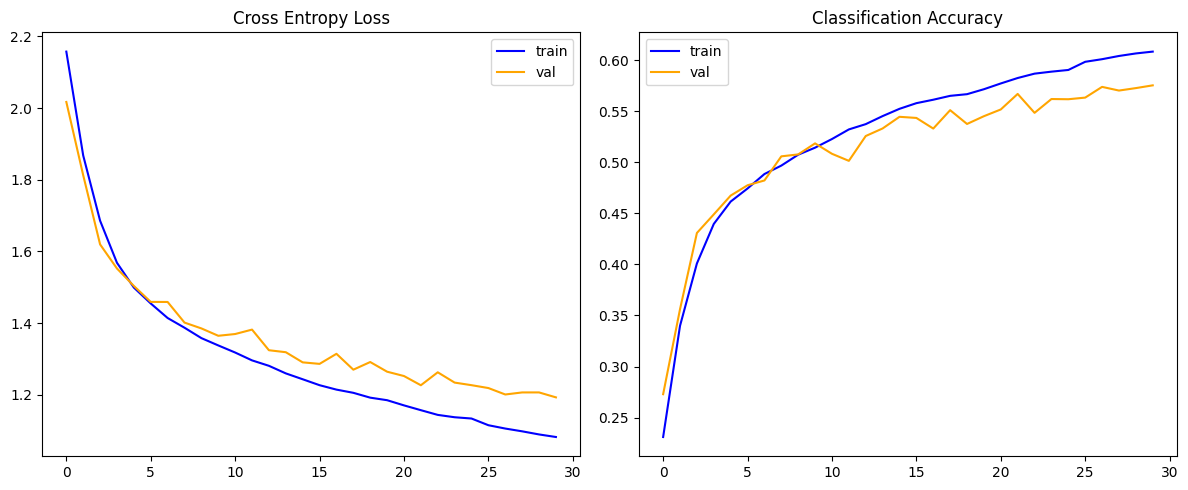

313/313 [==============================] - 1s 2ms/step


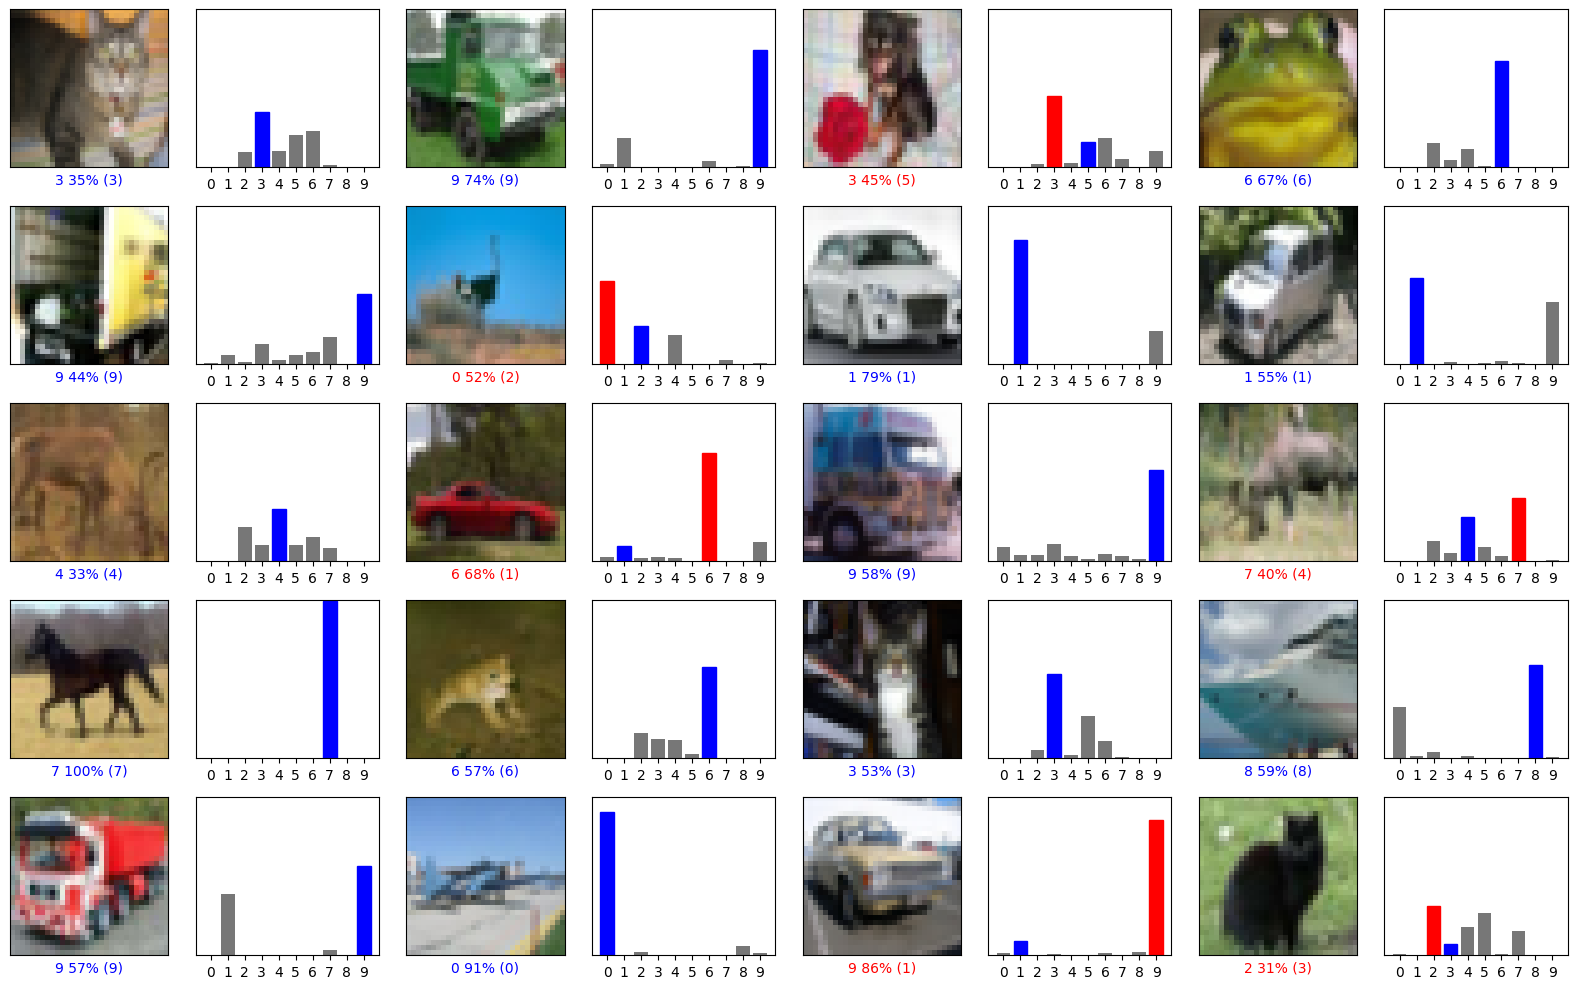


 Training time: 0:00:31.015251

 Train accuracy: 0.612

 Test accuracy: 0.573


In [ ]:
# Model loading with prepared data
tester = CIFAR10ModelTester(x_train = x_train_scaled, y_train = y_train,
                            x_val = x_val_scaled, y_val = y_val,
                            x_test = x_test_scaled, y_test = y_test)

# Model testing
model, history, model_info = tester.test_model(model, model_nr=model_nr, epochs=30)

#merge model_info with dataframe
model_info_df = pd.DataFrame.from_dict(model_info, orient='index').T # convert dictionary to dataframe and transpose

#For the first model, model_info_df is models_compare_df
models_compare_df = model_info_df

models_compare_df.set_index('Model_nr', inplace=True)

# Model and stats saving
model.save(path+f'cifar10_model_{model_nr}.h5')
models_compare_df.to_csv(path+'models_compare_df.csv')

## Model 1

Adding:

- **Increase epochs:** Extending training to 100 epochs allows the model to better learn data patterns.
- **Add early stopping:** Prevents overfitting by stopping training when validation performance plateaus.

### Model metrics:

**Test accuracy: 0.609**

In [ ]:
earlystop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

callbacks = [earlystop]

Epoch 1/100
79/79 [==============================] - 3s 19ms/step - loss: 2.1182 - accuracy: 0.2282 - val_loss: 1.9951 - val_accuracy: 0.2920
Epoch 2/100
79/79 [==============================] - 1s 10ms/step - loss: 1.8171 - accuracy: 0.3478 - val_loss: 1.6987 - val_accuracy: 0.3889
Epoch 3/100
79/79 [==============================] - 1s 11ms/step - loss: 1.5996 - accuracy: 0.4243 - val_loss: 1.5471 - val_accuracy: 0.4514
Epoch 4/100
79/79 [==============================] - 1s 11ms/step - loss: 1.4900 - accuracy: 0.4604 - val_loss: 1.4720 - val_accuracy: 0.4709
Epoch 5/100
79/79 [==============================] - 1s 13ms/step - loss: 1.4332 - accuracy: 0.4808 - val_loss: 1.4419 - val_accuracy: 0.4828
Epoch 6/100
79/79 [==============================] - 1s 13ms/step - loss: 1.3850 - accuracy: 0.5017 - val_loss: 1.5027 - val_accuracy: 0.4621
Epoch 7/100
79/79 [==============================] - 1s 14ms/step - loss: 1.3596 - accuracy: 0.5102 - val_loss: 1.3717 - val_accuracy: 0.5094
Epoch 

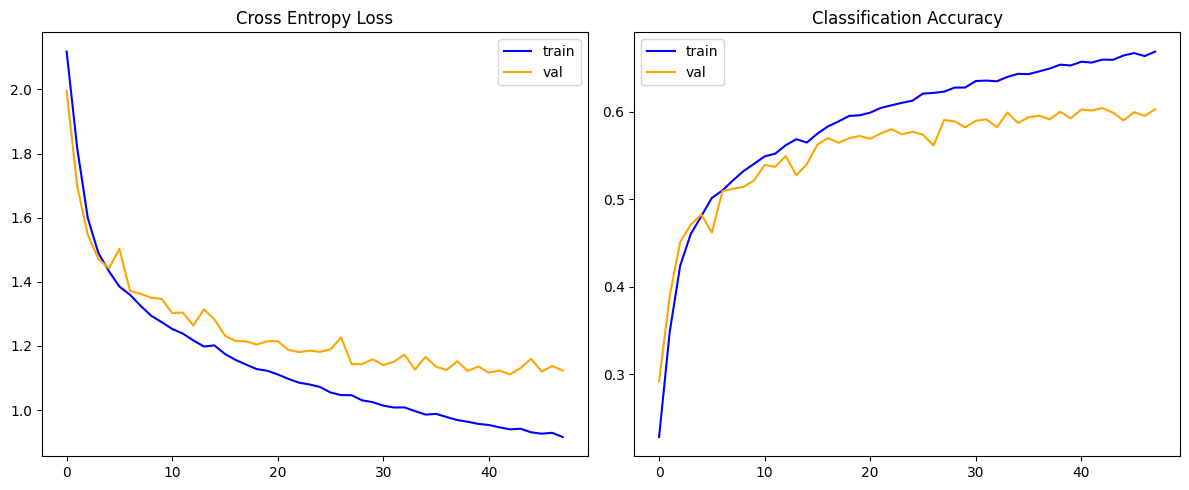

313/313 [==============================] - 1s 2ms/step


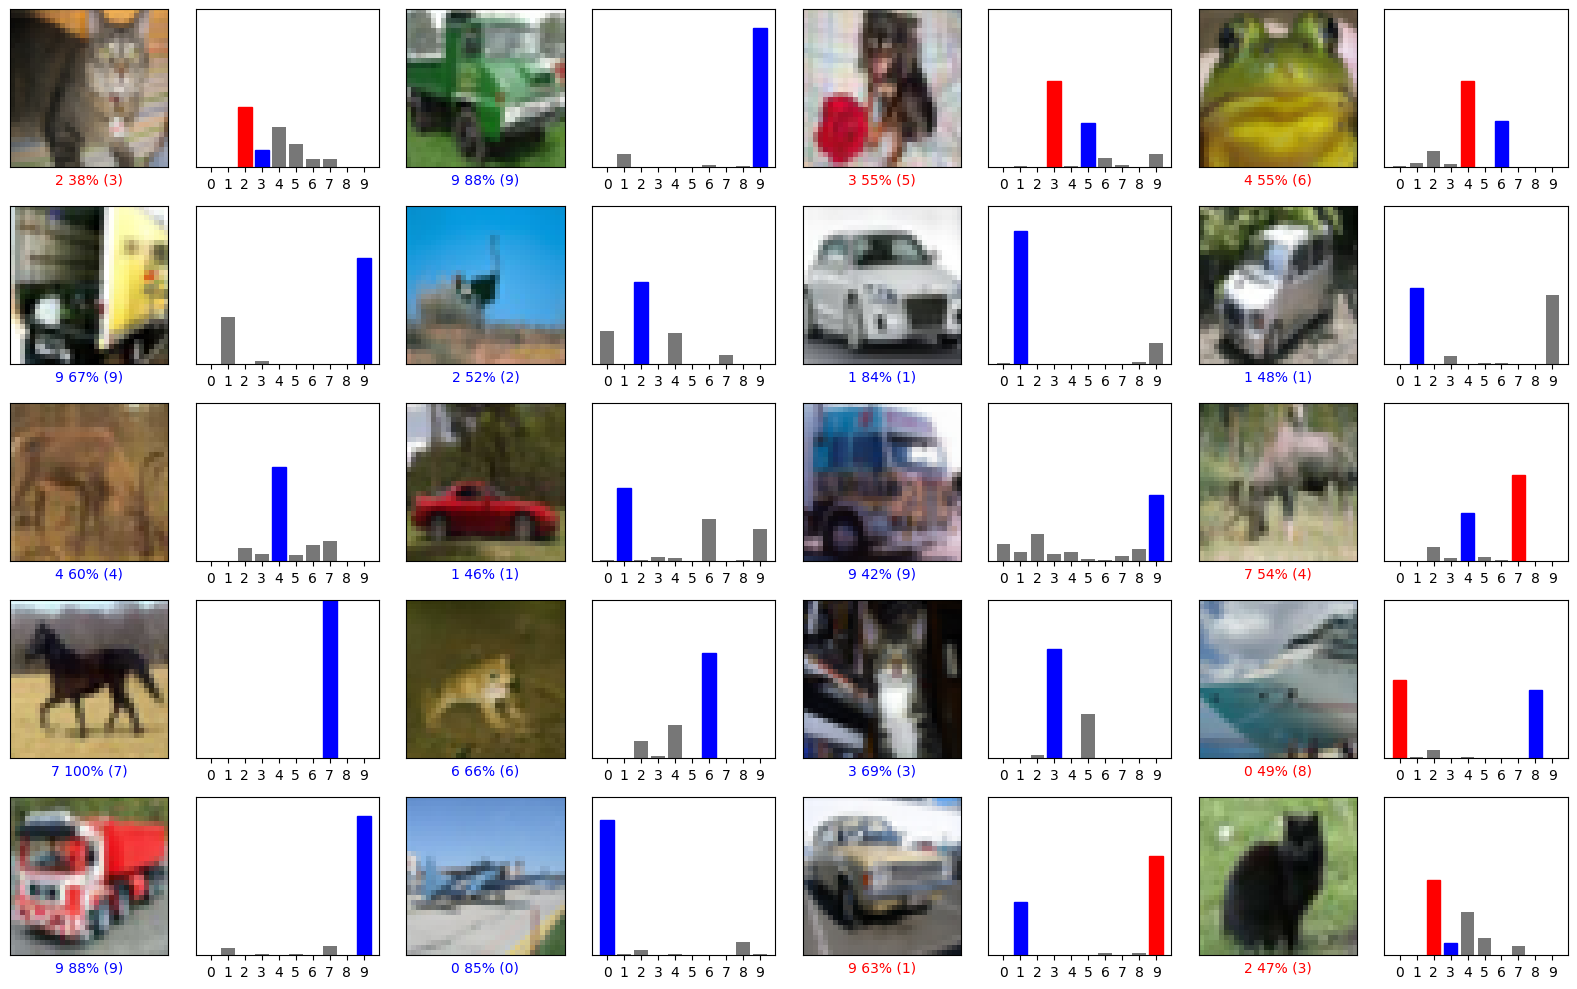


 Training time: 0:00:47.752717

 Train accuracy: 0.669

 Test accuracy: 0.609


In [ ]:
model_nr = 1
epochs = 100

# Model arch (same as base)
model = ks.Sequential([
    ks.layers.Conv2D(32, (3, 3), strides=1, activation='relu', padding='same', input_shape=(32, 32, 3)),
    ks.layers.MaxPooling2D((2, 2)),
    ks.layers.Flatten(),
    ks.layers.Dense(32, activation='relu'),
    ks.layers.Dense(10, activation='softmax')
])

# Model loading with prepared data
tester = CIFAR10ModelTester(x_train = x_train_scaled, y_train = y_train,
                            x_val = x_val_scaled, y_val = y_val,
                            x_test = x_test_scaled, y_test = y_test)

# Model testing
model, history, model_info = tester.test_model(model, model_nr=model_nr, epochs=epochs, callbacks=callbacks)

#merge model_info with dataframe
model_info_df = pd.DataFrame.from_dict(model_info, orient='index').T # convert dictionary to dataframe and transpose
model_info_df.set_index('Model_nr', inplace=True)

models_compare_df = models_compare_df.merge(model_info_df, how='outer')

# Model and stats saving
model.save(path+f'cifar10_model_{model_nr}.h5')
models_compare_df.to_csv(path+'models_compare_df.csv')

## Model 2

Adding:

- **Add a second convolutional layer with 64 filters:** Introducing an additional convolutional layer with more filters allows the model to learn a wider array of complex features, leading to improved accuracy.

### Model metrics:

**Test accuracy: 0.697**

Epoch 1/100
79/79 [==============================] - 3s 23ms/step - loss: 1.9363 - accuracy: 0.2977 - val_loss: 1.7328 - val_accuracy: 0.3771
Epoch 2/100
79/79 [==============================] - 1s 16ms/step - loss: 1.5755 - accuracy: 0.4334 - val_loss: 1.5447 - val_accuracy: 0.4383
Epoch 3/100
79/79 [==============================] - 1s 15ms/step - loss: 1.4375 - accuracy: 0.4855 - val_loss: 1.4424 - val_accuracy: 0.4819
Epoch 4/100
79/79 [==============================] - 1s 16ms/step - loss: 1.3543 - accuracy: 0.5181 - val_loss: 1.3856 - val_accuracy: 0.5073
Epoch 5/100
79/79 [==============================] - 1s 15ms/step - loss: 1.2889 - accuracy: 0.5437 - val_loss: 1.2998 - val_accuracy: 0.5439
Epoch 6/100
79/79 [==============================] - 1s 16ms/step - loss: 1.2329 - accuracy: 0.5644 - val_loss: 1.2499 - val_accuracy: 0.5674
Epoch 7/100
79/79 [==============================] - 1s 17ms/step - loss: 1.1803 - accuracy: 0.5863 - val_loss: 1.2246 - val_accuracy: 0.5674
Epoch 

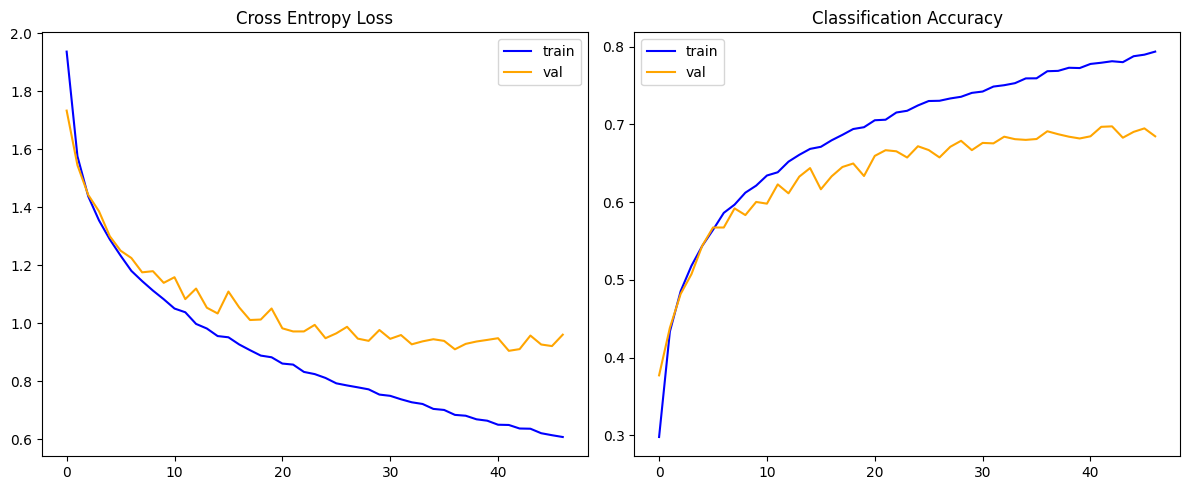

313/313 [==============================] - 1s 3ms/step


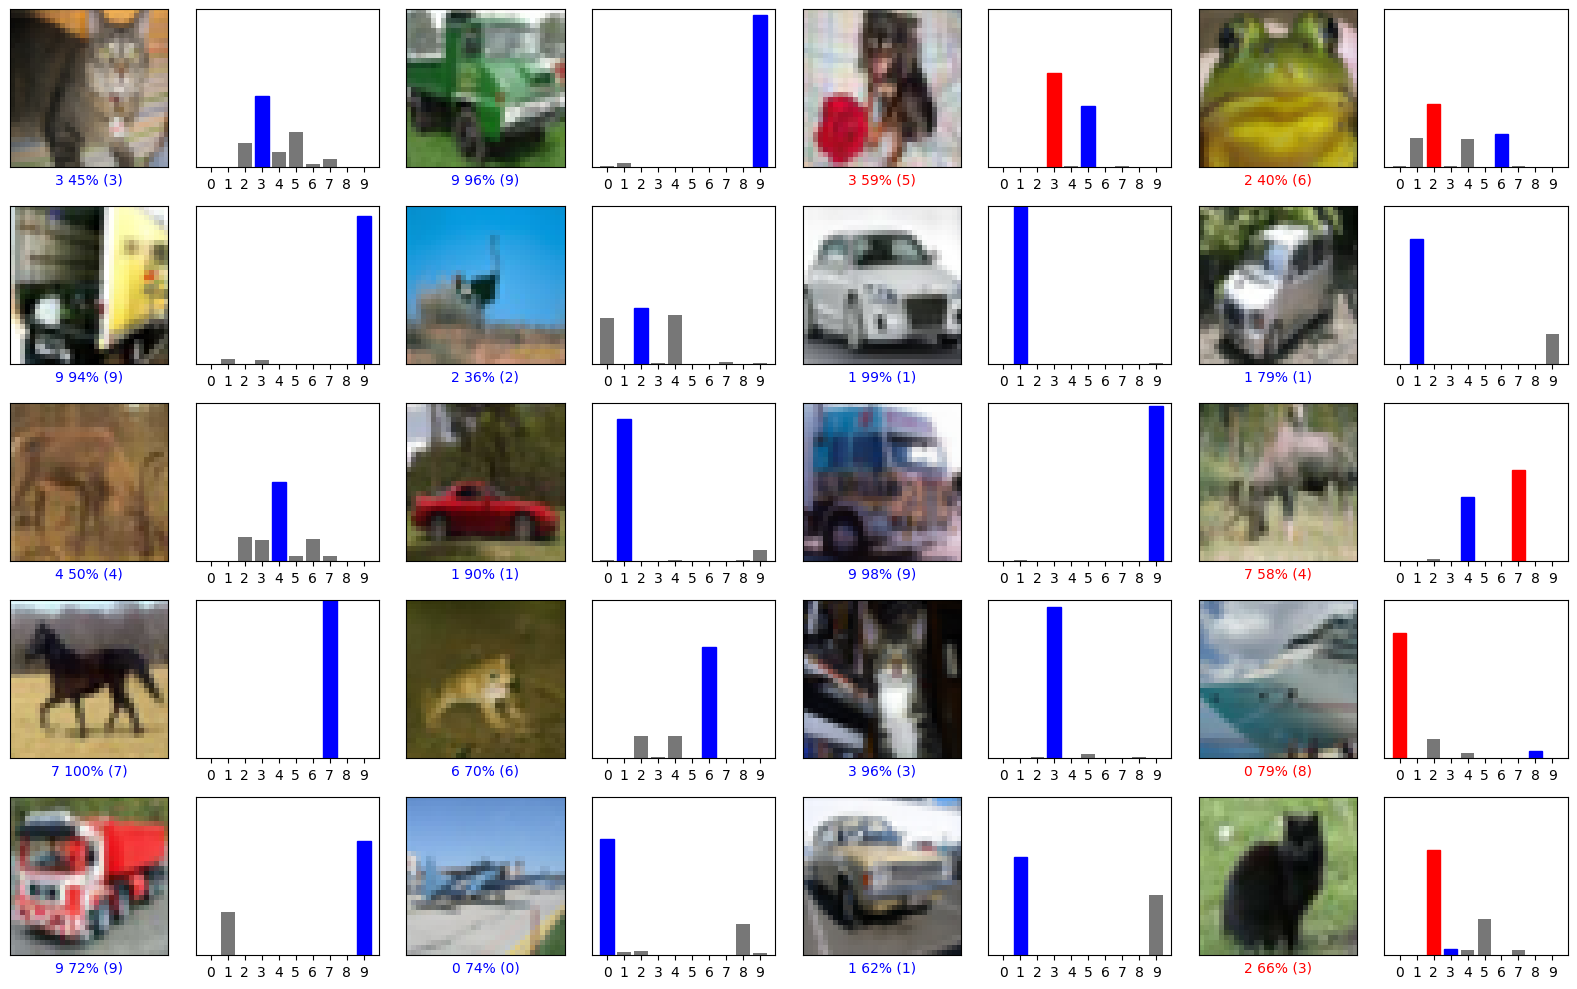


 Training time: 0:01:03.471689

 Train accuracy: 0.798

 Test accuracy: 0.697


In [ ]:
model_nr = 2

model = ks.Sequential([
    ks.layers.Conv2D(32, (3, 3), strides=1, activation='relu', padding='same', input_shape=(32, 32, 3)),
    ks.layers.MaxPooling2D((2, 2)),

    ks.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    ks.layers.MaxPooling2D((2, 2)),

    ks.layers.Flatten(),
    ks.layers.Dense(32, activation='relu'),
    ks.layers.Dense(10, activation='softmax')
])

# Model loading with prepared data
tester = CIFAR10ModelTester(x_train = x_train_scaled, y_train = y_train,
                            x_val = x_val_scaled, y_val = y_val,
                            x_test = x_test_scaled, y_test = y_test)

# Model testing
model, history, model_info = tester.test_model(model, model_nr=model_nr, epochs=epochs, callbacks=callbacks)

#merge model_info with dataframe
model_info_df = pd.DataFrame.from_dict(model_info, orient='index').T # convert dictionary to dataframe and transpose
model_info_df.set_index('Model_nr', inplace=True)

models_compare_df = models_compare_df.merge(model_info_df, how='outer')

# Model and stats saving
model.save(path+f'cifar10_model_{model_nr}.h5')
models_compare_df.to_csv(path+'models_compare_df.csv')

## Model 3

Adding:

- **Added batch normalization layers:** After each convolutional layer, to normalize activations and accelerate training.

- **Moved ReLU activation after batch normalization:** necessary after applying batch normalization

- **Increased the number of units in the hidden dense layer to 64**: to enhance the model's capacity to learn complex representations.

### Model metrics:

**Test accuracy: 0.688**

Epoch 1/100
79/79 [==============================] - 4s 31ms/step - loss: 2.0392 - accuracy: 0.3212 - val_loss: 2.3727 - val_accuracy: 0.1229
Epoch 2/100
79/79 [==============================] - 2s 25ms/step - loss: 1.4099 - accuracy: 0.4932 - val_loss: 2.9314 - val_accuracy: 0.1072
Epoch 3/100
79/79 [==============================] - 2s 24ms/step - loss: 1.2244 - accuracy: 0.5666 - val_loss: 2.9900 - val_accuracy: 0.1391
Epoch 4/100
79/79 [==============================] - 2s 23ms/step - loss: 1.1081 - accuracy: 0.6106 - val_loss: 2.6028 - val_accuracy: 0.1737
Epoch 5/100
79/79 [==============================] - 2s 21ms/step - loss: 1.0299 - accuracy: 0.6381 - val_loss: 1.9122 - val_accuracy: 0.3298
Epoch 6/100
79/79 [==============================] - 2s 21ms/step - loss: 0.9558 - accuracy: 0.6678 - val_loss: 1.5014 - val_accuracy: 0.4834
Epoch 7/100
79/79 [==============================] - 2s 21ms/step - loss: 0.8970 - accuracy: 0.6871 - val_loss: 1.1481 - val_accuracy: 0.5956
Epoch 

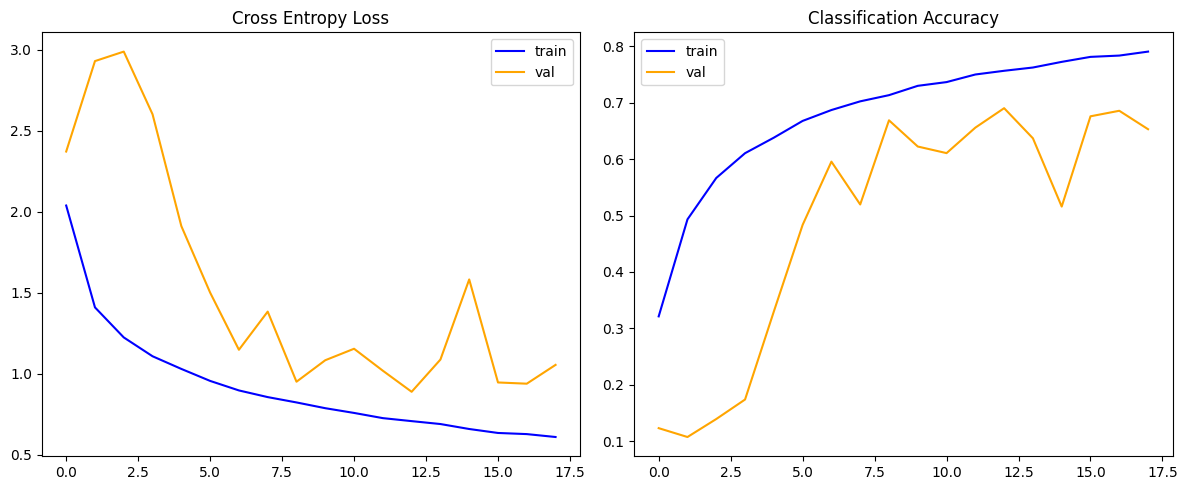

313/313 [==============================] - 1s 2ms/step


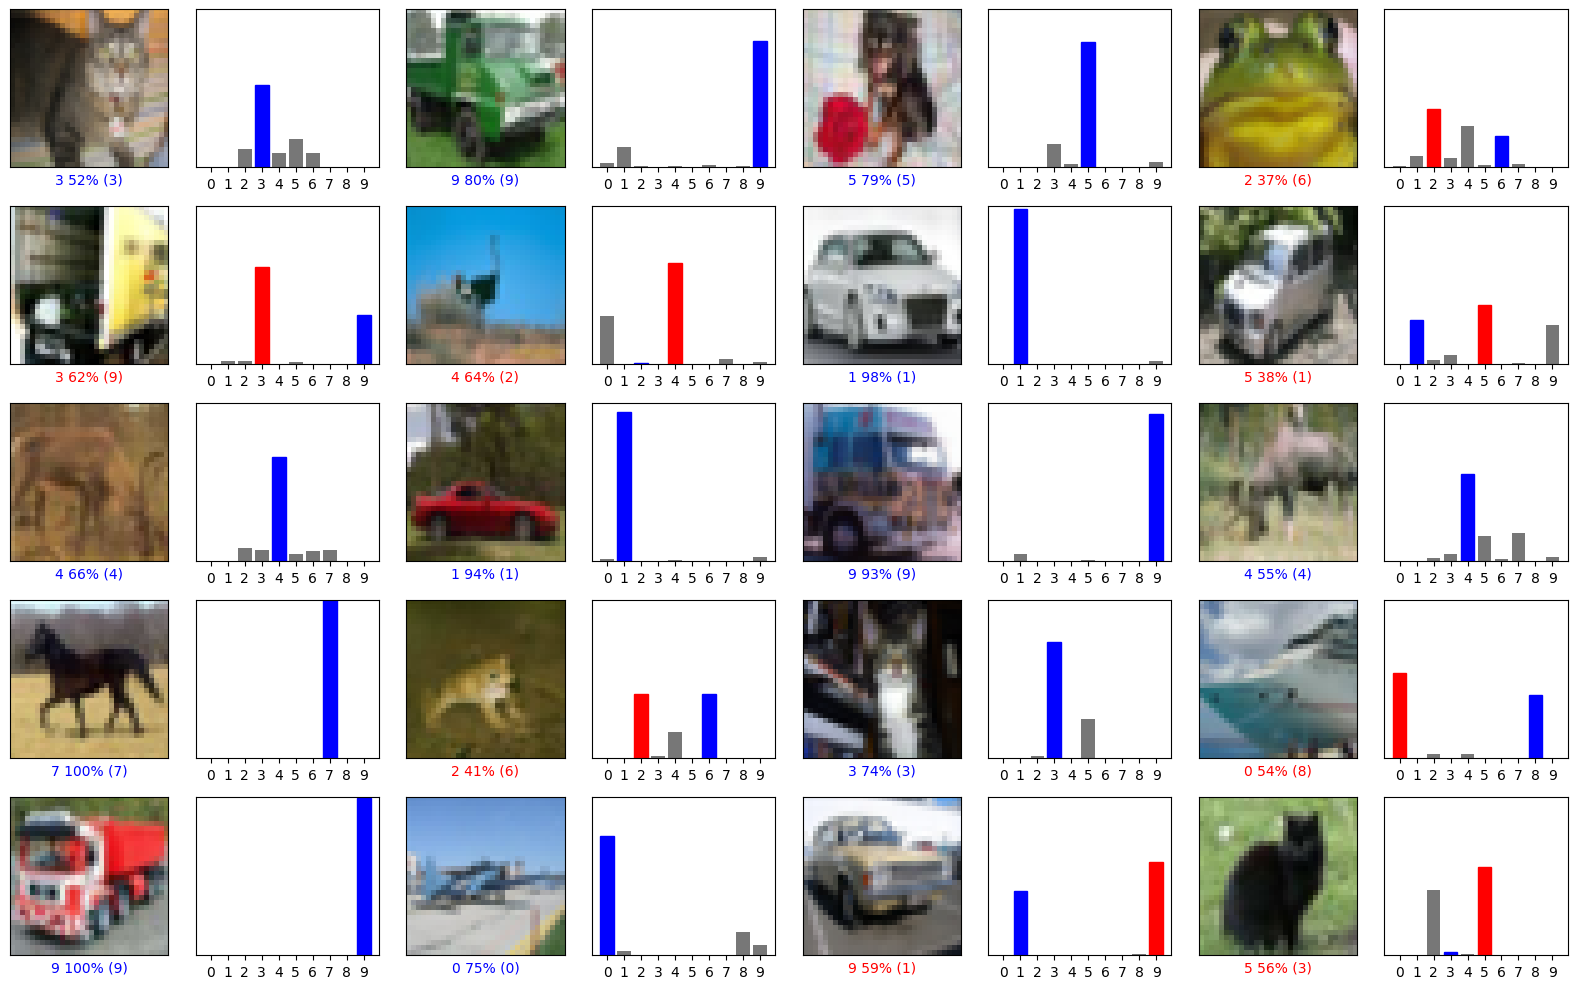


 Training time: 0:00:36.280714

 Train accuracy: 0.760

 Test accuracy: 0.688


In [ ]:
model_nr = 3

model = ks.Sequential([
    ks.layers.Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3)),
    ks.layers.BatchNormalization(),
    ks.layers.Activation('relu'),
    ks.layers.MaxPooling2D((2, 2)),

    ks.layers.Conv2D(64, (3, 3), padding='same'),
    ks.layers.BatchNormalization(),
    ks.layers.Activation('relu'),
    ks.layers.MaxPooling2D((2, 2)),

    ks.layers.Flatten(),
    ks.layers.Dense(64, activation='relu'),
    ks.layers.Dense(10, activation='softmax')
])

# Model loading with prepared data
tester = CIFAR10ModelTester(x_train = x_train_scaled, y_train = y_train,
                            x_val = x_val_scaled, y_val = y_val,
                            x_test = x_test_scaled, y_test = y_test)

# Model testing
model, history, model_info = tester.test_model(model, model_nr=model_nr, epochs=epochs, callbacks=callbacks)

#merge model_info with dataframe
model_info_df = pd.DataFrame.from_dict(model_info, orient='index').T # convert dictionary to dataframe and transpose
model_info_df.set_index('Model_nr', inplace=True)

models_compare_df = models_compare_df.merge(model_info_df, how='outer')

# Model and stats saving
model.save(path+f'cifar10_model_{model_nr}.h5')
models_compare_df.to_csv(path+'models_compare_df.csv')

## Model 4

Model 3 was worse than model 2 on test. On train data they worked similarly. So I will add dropout to avoid overfitting.

Adding:

- **Adding dropout after every layer:** to mitigate overfitting by randomly deactivating neurons during training, forcing the network to learn more robust and generalizable features.

### Model metrics:

**Test accuracy: 0.724**

Epoch 1/100
79/79 [==============================] - 6s 37ms/step - loss: 2.1185 - accuracy: 0.2379 - val_loss: 3.5386 - val_accuracy: 0.0962
Epoch 2/100
79/79 [==============================] - 3s 33ms/step - loss: 1.7744 - accuracy: 0.3385 - val_loss: 5.9601 - val_accuracy: 0.0952
Epoch 3/100
79/79 [==============================] - 3s 35ms/step - loss: 1.6409 - accuracy: 0.3923 - val_loss: 7.7526 - val_accuracy: 0.0953
Epoch 4/100
79/79 [==============================] - 2s 30ms/step - loss: 1.5379 - accuracy: 0.4274 - val_loss: 5.8312 - val_accuracy: 0.1082
Epoch 5/100
79/79 [==============================] - 2s 29ms/step - loss: 1.4743 - accuracy: 0.4521 - val_loss: 3.7181 - val_accuracy: 0.1930
Epoch 6/100
79/79 [==============================] - 2s 31ms/step - loss: 1.4263 - accuracy: 0.4744 - val_loss: 2.5712 - val_accuracy: 0.3275
Epoch 7/100
79/79 [==============================] - 2s 29ms/step - loss: 1.3707 - accuracy: 0.4970 - val_loss: 1.4195 - val_accuracy: 0.5100
Epoch 

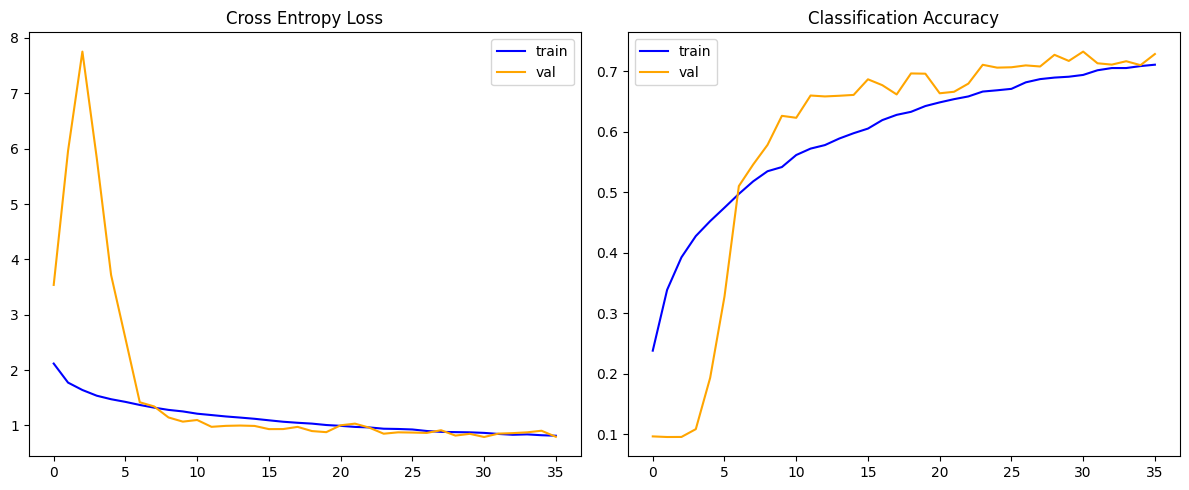

313/313 [==============================] - 1s 2ms/step


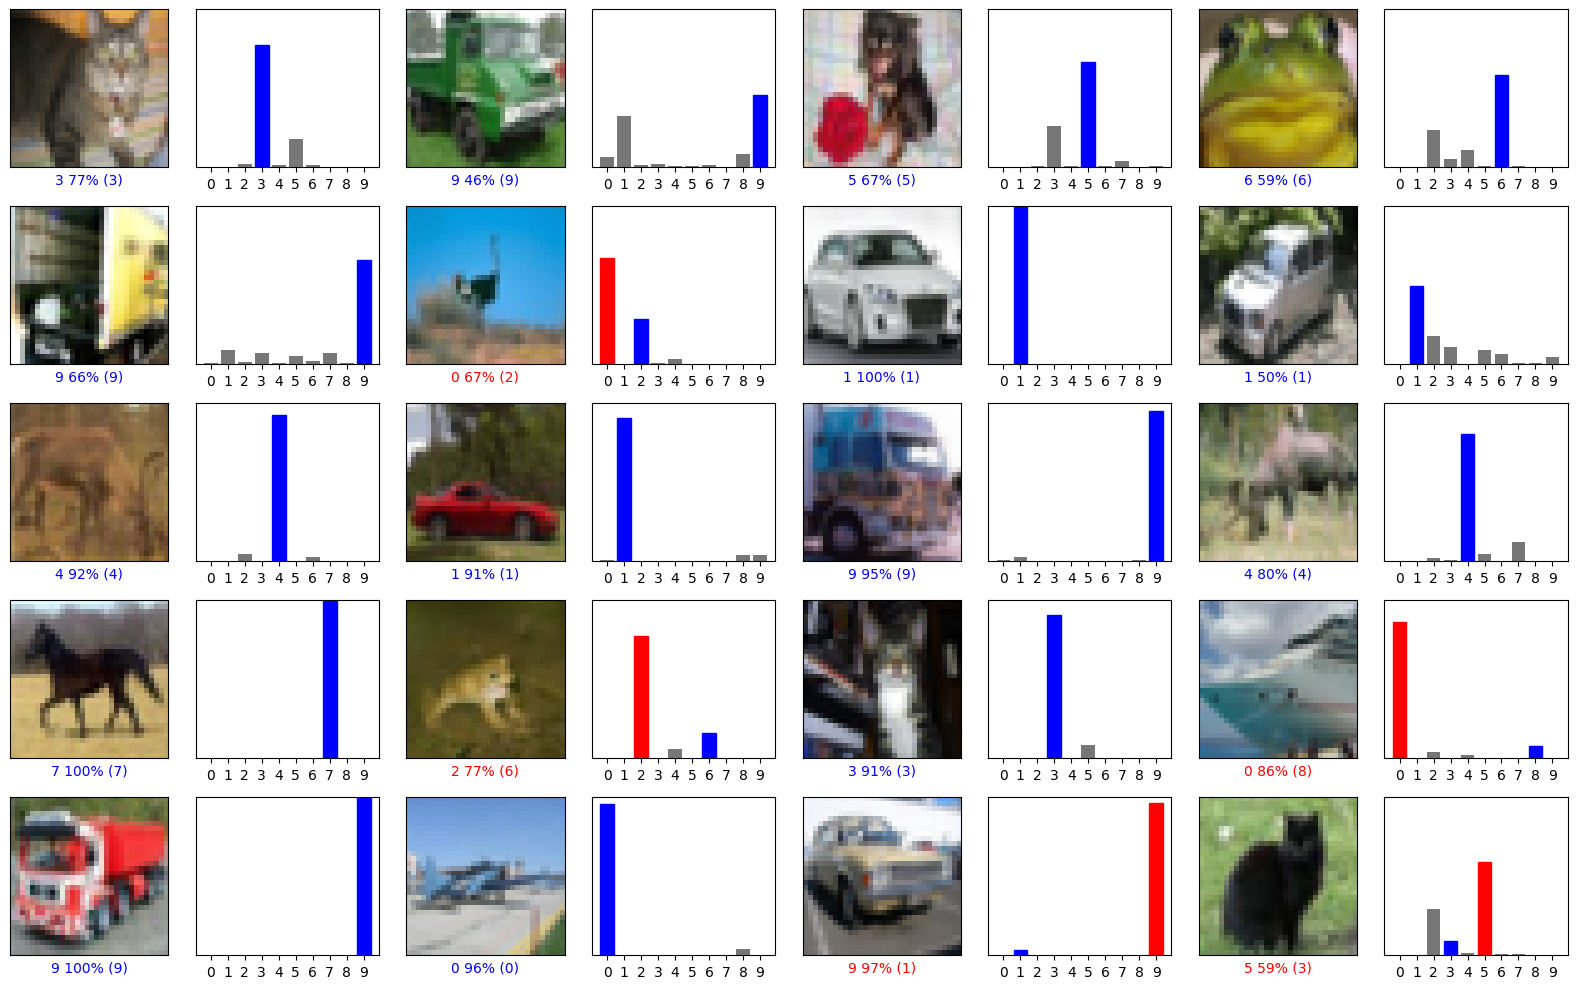


 Training time: 0:01:32.057246

 Train accuracy: 0.806

 Test accuracy: 0.724


In [ ]:
model_nr = 4

model = ks.Sequential([
    ks.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    ks.layers.BatchNormalization(),
    ks.layers.MaxPooling2D((2, 2)),
    ks.layers.Dropout(0.25),

    ks.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    ks.layers.BatchNormalization(),
    ks.layers.MaxPooling2D((2, 2)),
    ks.layers.Dropout(0.25),

    ks.layers.Flatten(),
    ks.layers.Dense(64, activation='relu'),
    ks.layers.Dropout(0.5),
    ks.layers.Dense(10, activation='softmax')
])

# Model loading with prepared data
tester = CIFAR10ModelTester(x_train = x_train_scaled, y_train = y_train,
                            x_val = x_val_scaled, y_val = y_val,
                            x_test = x_test_scaled, y_test = y_test)

# Model testing
model, history, model_info = tester.test_model(model, model_nr=model_nr, epochs=epochs, callbacks=callbacks)

#merge model_info with dataframe
model_info_df = pd.DataFrame.from_dict(model_info, orient='index').T # convert dictionary to dataframe and transpose
model_info_df.set_index('Model_nr', inplace=True)

models_compare_df = models_compare_df.merge(model_info_df, how='outer')

# Model and stats saving
model.save(path+f'cifar10_model_{model_nr}.h5')
models_compare_df.to_csv(path+'models_compare_df.csv')

print(models_compare_df)

## Model 5

I will increase model complexity by:

- **Increased network depth:** The model now has three convolutional blocks instead of two, allowing it to learn more complex features.
- **More filters:** Starting with 64 filters and increasing to 256, the model can capture a wider range of features.
- **Double Conv2D layers:** Each block now has two Conv2D layers, which helps in learning more complex patterns.
- **Gradual increase in dropout:** Dropout rates increase from 0.2 to 0.5 as we go deeper into the network, helping prevent overfitting.
- **Larger dense layer:** The final dense layer before the output layer now has 512 units, allowing for more complex representations.

### Model metrics:

**Test accuracy: 0.817**

Epoch 1/100
79/79 [==============================] - 26s 202ms/step - loss: 2.3343 - accuracy: 0.3202 - val_loss: 2.5367 - val_accuracy: 0.0985
Epoch 2/100
79/79 [==============================] - 12s 153ms/step - loss: 1.4973 - accuracy: 0.4590 - val_loss: 3.4921 - val_accuracy: 0.1496
Epoch 3/100
79/79 [==============================] - 12s 152ms/step - loss: 1.2822 - accuracy: 0.5391 - val_loss: 3.7611 - val_accuracy: 0.1373
Epoch 4/100
79/79 [==============================] - 12s 153ms/step - loss: 1.1191 - accuracy: 0.6027 - val_loss: 3.6013 - val_accuracy: 0.1934
Epoch 5/100
79/79 [==============================] - 12s 153ms/step - loss: 0.9937 - accuracy: 0.6494 - val_loss: 3.4188 - val_accuracy: 0.1455
Epoch 6/100
79/79 [==============================] - 12s 152ms/step - loss: 0.8926 - accuracy: 0.6870 - val_loss: 2.4211 - val_accuracy: 0.3167
Epoch 7/100
79/79 [==============================] - 12s 153ms/step - loss: 0.8025 - accuracy: 0.7177 - val_loss: 1.3260 - val_accuracy:

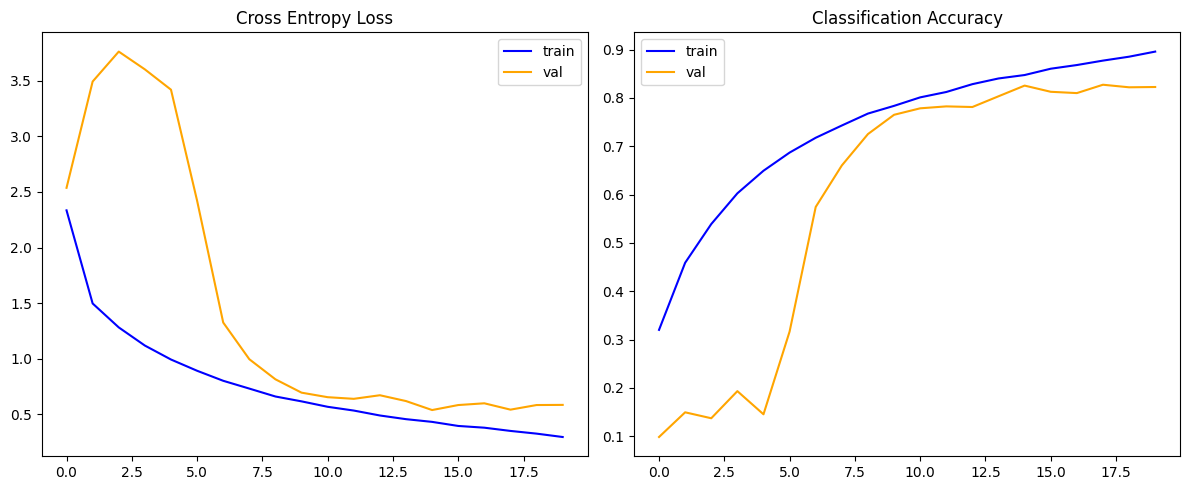

313/313 [==============================] - 2s 4ms/step


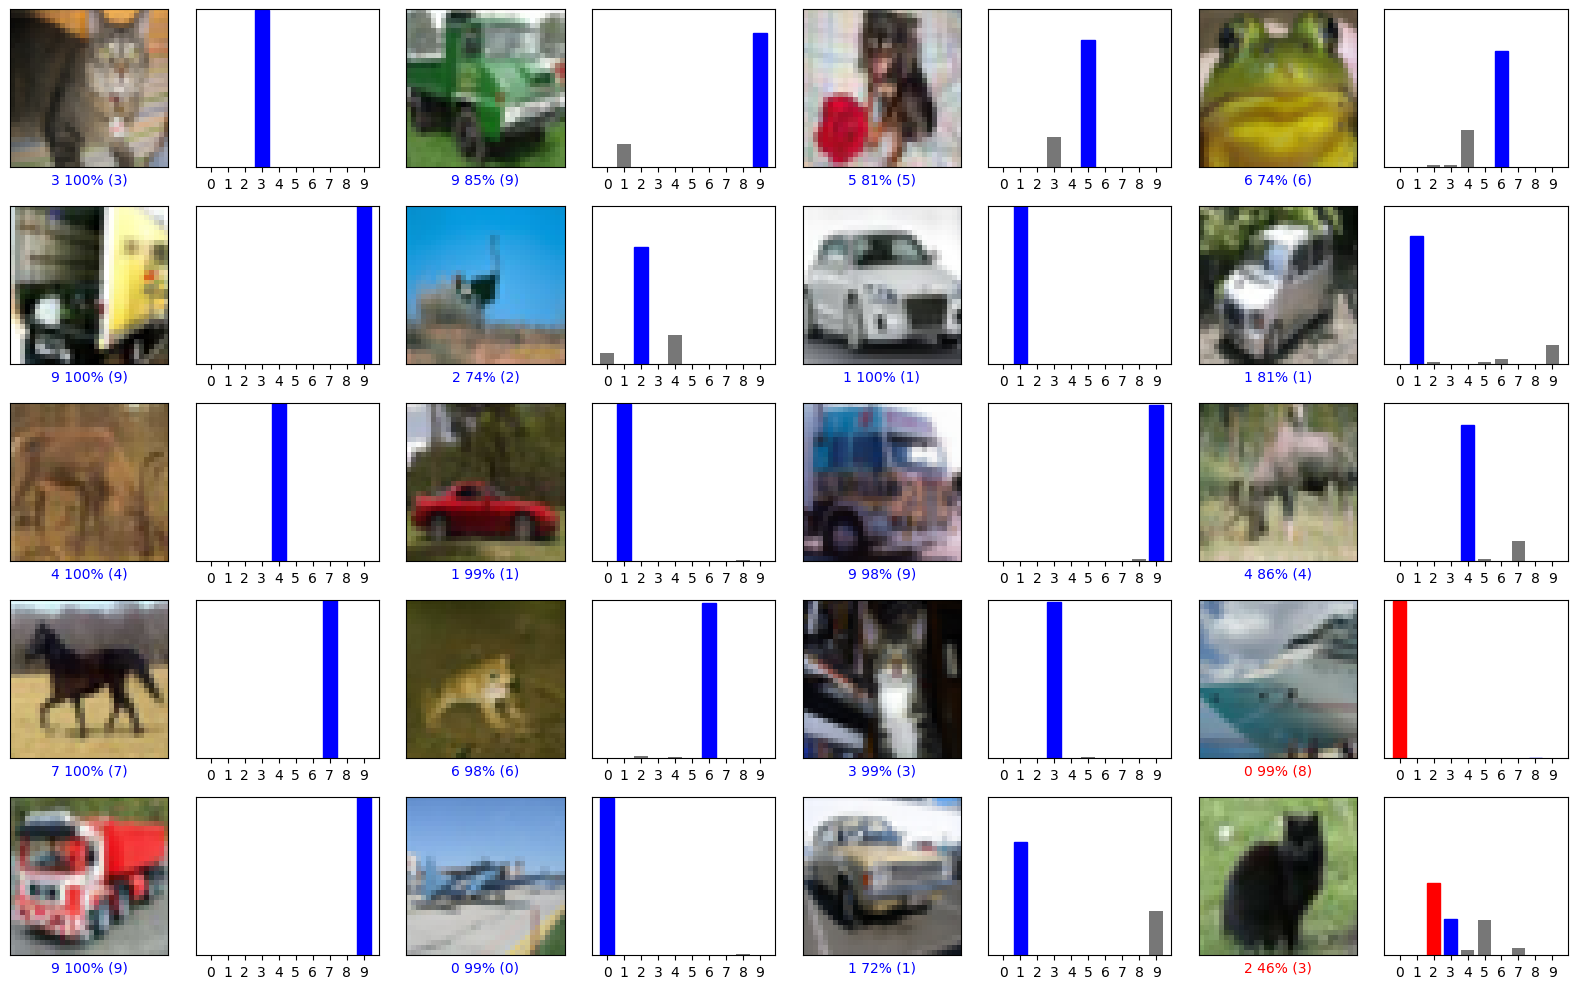


 Training time: 0:04:16.867676

 Train accuracy: 0.906

 Test accuracy: 0.817
  Train_Accuracy Test_Accuracy Final_Loss      Train_time Num_Layers  \
0          0.612         0.573      1.082  0:00:31.015251          5   
1          0.669         0.609      0.916  0:00:47.752717          5   
2          0.798         0.697      0.607  0:01:03.471689          7   
3           0.76         0.688      0.609  0:00:36.280714         11   
4          0.806         0.724      0.815  0:01:32.057246         12   
5          0.906         0.817      0.297  0:04:16.867676         22   

  Num_Neurons Total_Params Batch_Size Optimizer  \
0          42       263402        512      adam   
1          42       263402        512      adam   
2          42       150826        512      adam   
3          74       282634        512      adam   
4          74       282634        512      adam   
5         522      3251786        512      adam   

                     Loss_Function Transfer_Learning Dropo

In [ ]:
model_nr = 5

model = ks.Sequential([
    # Convolutional Block 1
    ks.layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    ks.layers.BatchNormalization(),
    ks.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    ks.layers.BatchNormalization(),
    ks.layers.MaxPooling2D((2, 2)),
    ks.layers.Dropout(0.2),

    # Convolutional Block 2
    ks.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    ks.layers.BatchNormalization(),
    ks.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    ks.layers.BatchNormalization(),
    ks.layers.MaxPooling2D((2, 2)),
    ks.layers.Dropout(0.3),

    # Convolutional Block 3
    ks.layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    ks.layers.BatchNormalization(),
    ks.layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    ks.layers.BatchNormalization(),
    ks.layers.MaxPooling2D((2, 2)),
    ks.layers.Dropout(0.4),

    # Fully Connected Layers
    ks.layers.Flatten(),
    ks.layers.Dense(512, activation='relu'),
    ks.layers.Dropout(0.5),
    ks.layers.Dense(10, activation='softmax')
])


# Model loading with prepared data
tester = CIFAR10ModelTester(x_train = x_train_scaled, y_train = y_train,
                            x_val = x_val_scaled, y_val = y_val,
                            x_test = x_test_scaled, y_test = y_test)

# Model testing
model, history, model_info = tester.test_model(model, model_nr=model_nr, epochs=epochs, callbacks=callbacks)

#merge model_info with dataframe
model_info_df = pd.DataFrame.from_dict(model_info, orient='index').T # convert dictionary to dataframe and transpose
model_info_df.set_index('Model_nr', inplace=True)

models_compare_df = models_compare_df.merge(model_info_df, how='outer')

# Model and stats saving
model.save(path+f'cifar10_model_{model_nr}.h5')
models_compare_df.to_csv(path+'models_compare_df.csv')

print('\n', models_compare_df)

## Model 5.9

Using model 5 I tested **different batch sizes**

### Models metrics:

**Batch size 64: Test accuracy 0.817**
Training time: 0:05:28.748609

**Batch size 128: Test accuracy 0.836**
Training time: 0:06:39.570666

**Batch size 256: Test accuracy 0.852**
Training time: 0:08:50.508323

#### Second trial closer to 256:

**Batch size 160: Test accuracy 0.834**

**Batch size 192: Test accuracy 0.849**

**Batch size 224: Test accuracy 0.845**


Epoch 1/75
250/250 [==============================] - 19s 54ms/step - loss: 1.8160 - accuracy: 0.3832 - val_loss: 4.9040 - val_accuracy: 0.1167
Epoch 2/75
250/250 [==============================] - 12s 49ms/step - loss: 1.2460 - accuracy: 0.5565 - val_loss: 2.1389 - val_accuracy: 0.3686
Epoch 3/75
250/250 [==============================] - 12s 50ms/step - loss: 1.0108 - accuracy: 0.6467 - val_loss: 0.8959 - val_accuracy: 0.6865
Epoch 4/75
250/250 [==============================] - 13s 50ms/step - loss: 0.8690 - accuracy: 0.6959 - val_loss: 1.0842 - val_accuracy: 0.6282
Epoch 5/75
250/250 [==============================] - 13s 52ms/step - loss: 0.7710 - accuracy: 0.7333 - val_loss: 0.8120 - val_accuracy: 0.7218
Epoch 6/75
250/250 [==============================] - 13s 52ms/step - loss: 0.6928 - accuracy: 0.7623 - val_loss: 0.7355 - val_accuracy: 0.7476
Epoch 7/75
250/250 [==============================] - 13s 51ms/step - loss: 0.6263 - accuracy: 0.7827 - val_loss: 0.8142 - val_accuracy:

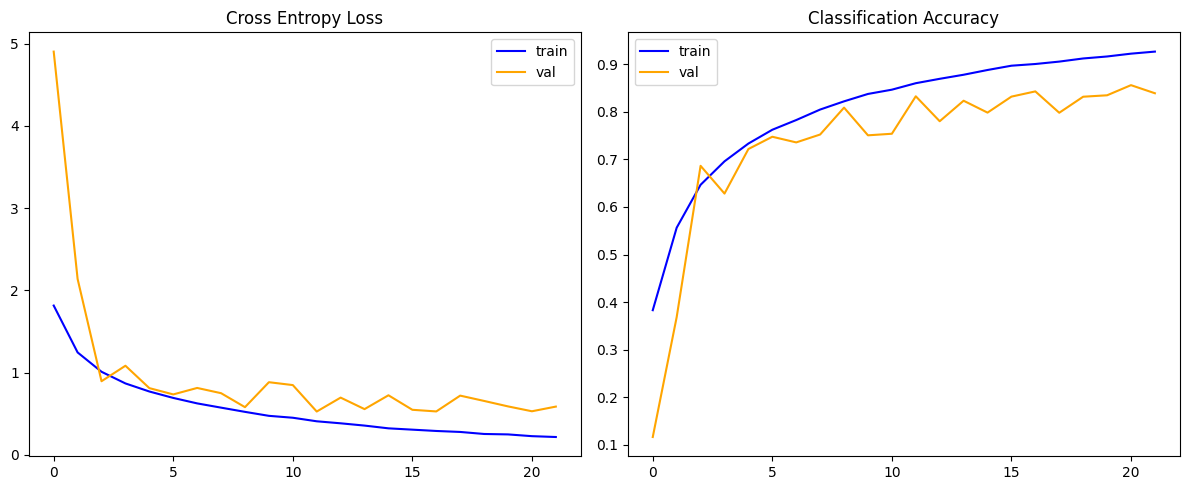

313/313 [==============================] - 2s 4ms/step


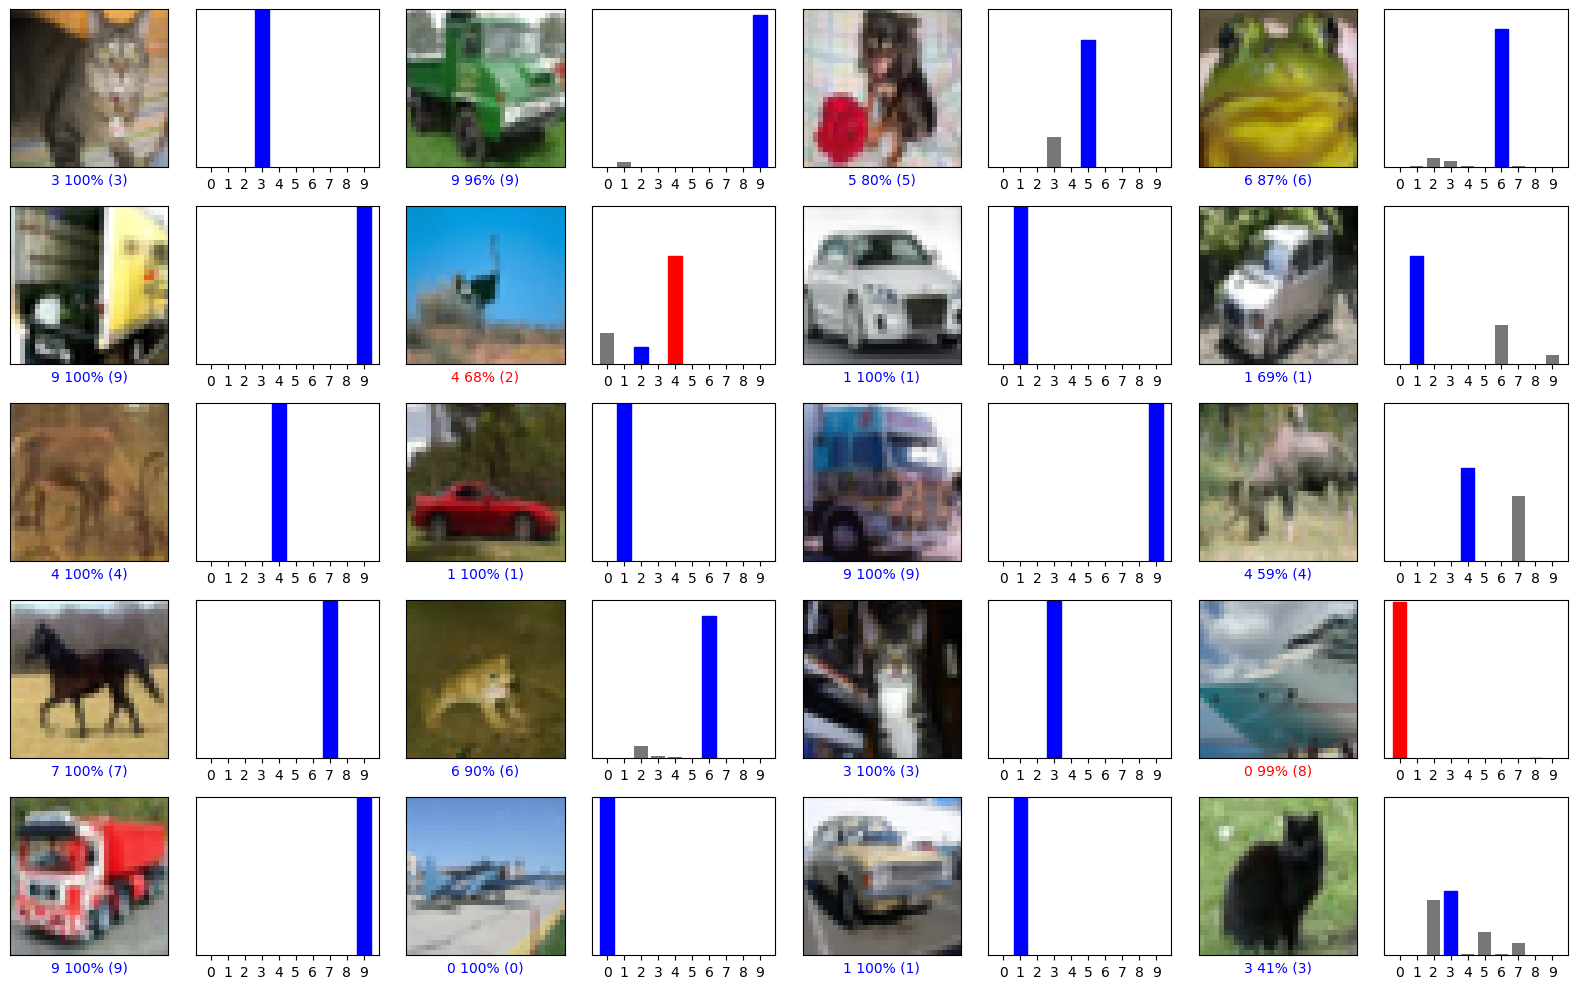


 Training time: 0:04:54.834612

 Train accuracy: 0.921

 Test accuracy: 0.834
Batch size 160: Test accuracy 0.834
Epoch 1/75
209/209 [==============================] - 21s 69ms/step - loss: 1.8125 - accuracy: 0.3911 - val_loss: 4.9572 - val_accuracy: 0.1464
Epoch 2/75
209/209 [==============================] - 14s 65ms/step - loss: 1.2665 - accuracy: 0.5489 - val_loss: 2.6955 - val_accuracy: 0.2690
Epoch 3/75
209/209 [==============================] - 13s 63ms/step - loss: 1.0594 - accuracy: 0.6283 - val_loss: 1.1858 - val_accuracy: 0.5632
Epoch 4/75
209/209 [==============================] - 14s 67ms/step - loss: 0.8944 - accuracy: 0.6893 - val_loss: 0.9260 - val_accuracy: 0.6854
Epoch 5/75
209/209 [==============================] - 14s 68ms/step - loss: 0.7906 - accuracy: 0.7277 - val_loss: 0.7514 - val_accuracy: 0.7390
Epoch 6/75
209/209 [==============================] - 14s 66ms/step - loss: 0.7199 - accuracy: 0.7526 - val_loss: 0.6985 - val_accuracy: 0.7554
Epoch 7/75
209/209 [=

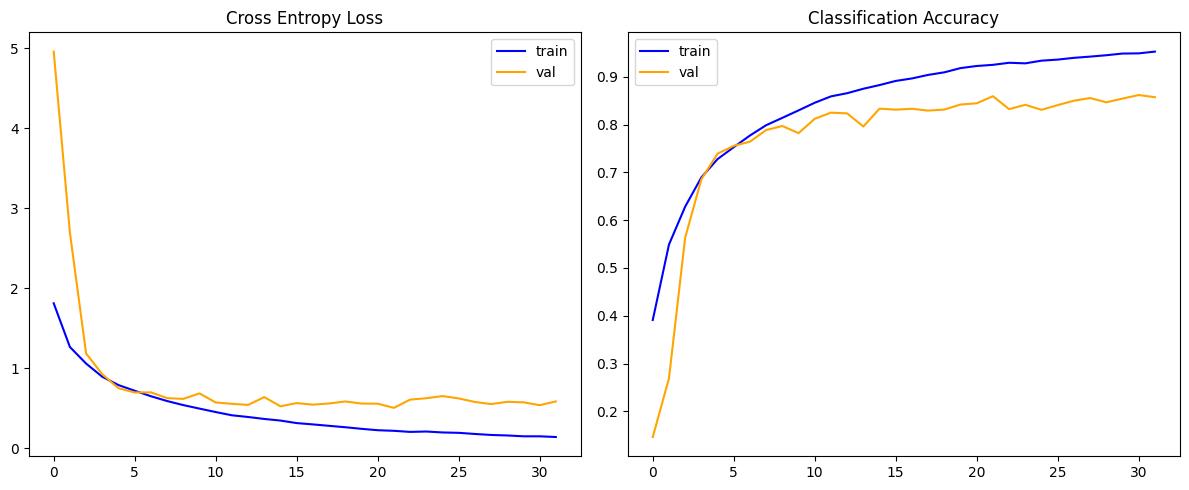

313/313 [==============================] - 1s 3ms/step


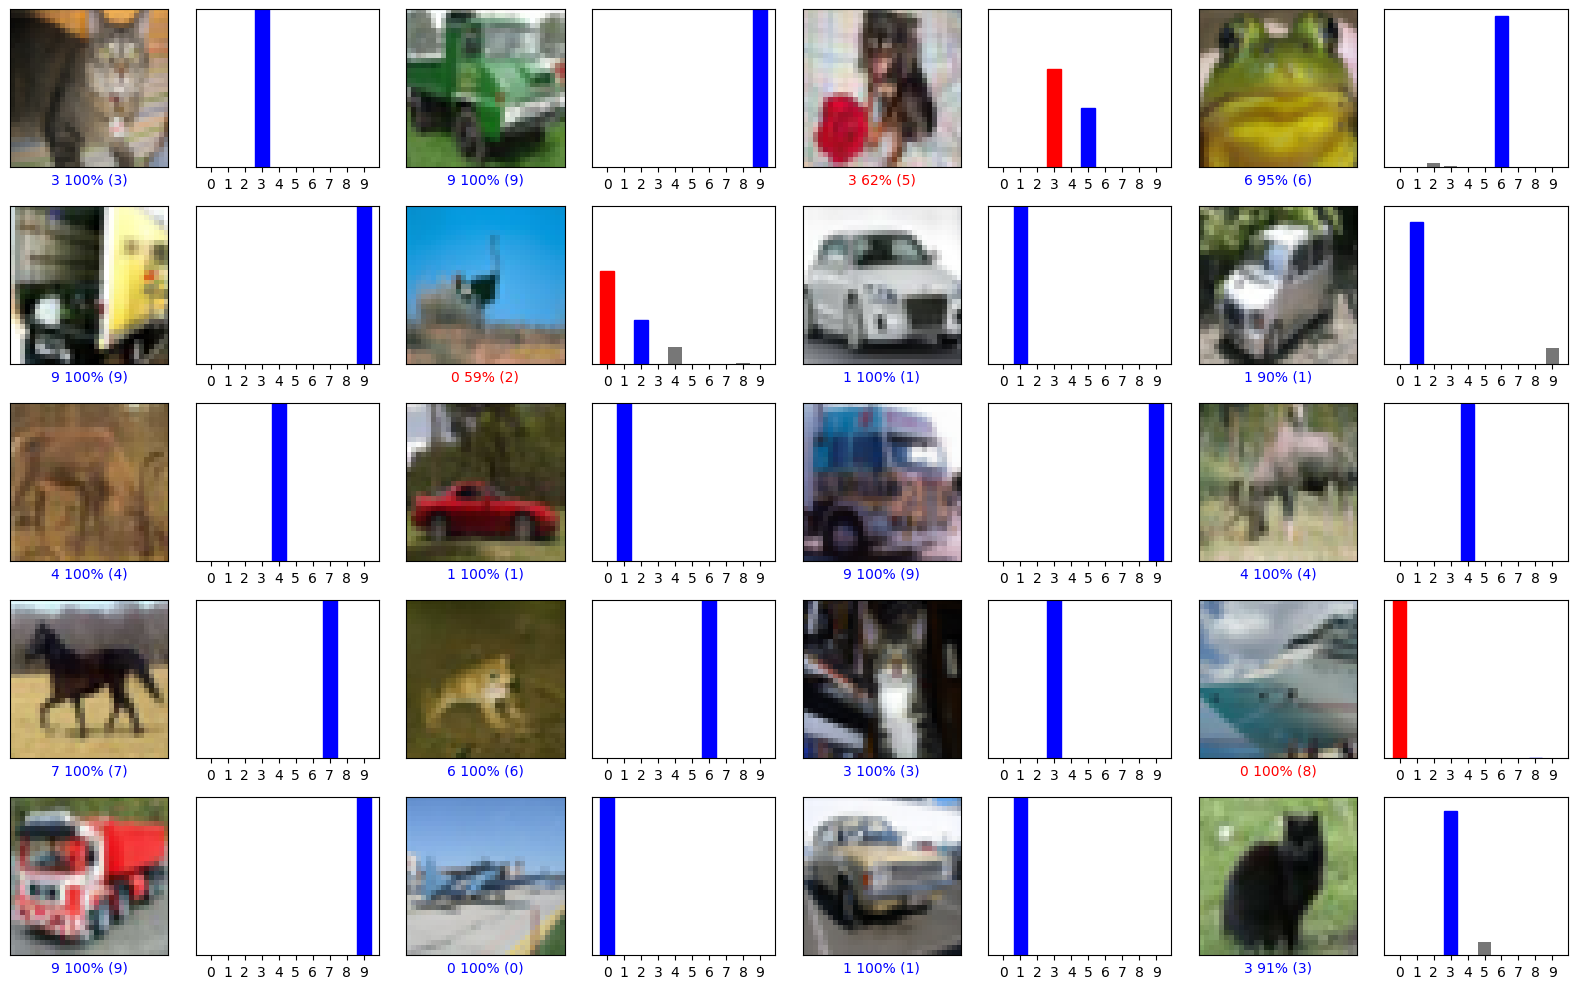


 Training time: 0:07:07.368250

 Train accuracy: 0.976

 Test accuracy: 0.849
Batch size 192: Test accuracy 0.849
Epoch 1/75
179/179 [==============================] - 26s 95ms/step - loss: 1.8934 - accuracy: 0.3794 - val_loss: 4.2355 - val_accuracy: 0.0961
Epoch 2/75
179/179 [==============================] - 13s 72ms/step - loss: 1.3089 - accuracy: 0.5297 - val_loss: 3.8591 - val_accuracy: 0.1891
Epoch 3/75
179/179 [==============================] - 13s 74ms/step - loss: 1.0835 - accuracy: 0.6176 - val_loss: 1.2406 - val_accuracy: 0.5575
Epoch 4/75
179/179 [==============================] - 14s 77ms/step - loss: 0.9201 - accuracy: 0.6784 - val_loss: 0.8279 - val_accuracy: 0.7142
Epoch 5/75
179/179 [==============================] - 14s 77ms/step - loss: 0.8162 - accuracy: 0.7169 - val_loss: 0.8198 - val_accuracy: 0.7172
Epoch 6/75
179/179 [==============================] - 13s 75ms/step - loss: 0.7418 - accuracy: 0.7410 - val_loss: 0.6486 - val_accuracy: 0.7743
Epoch 7/75
179/179 [=

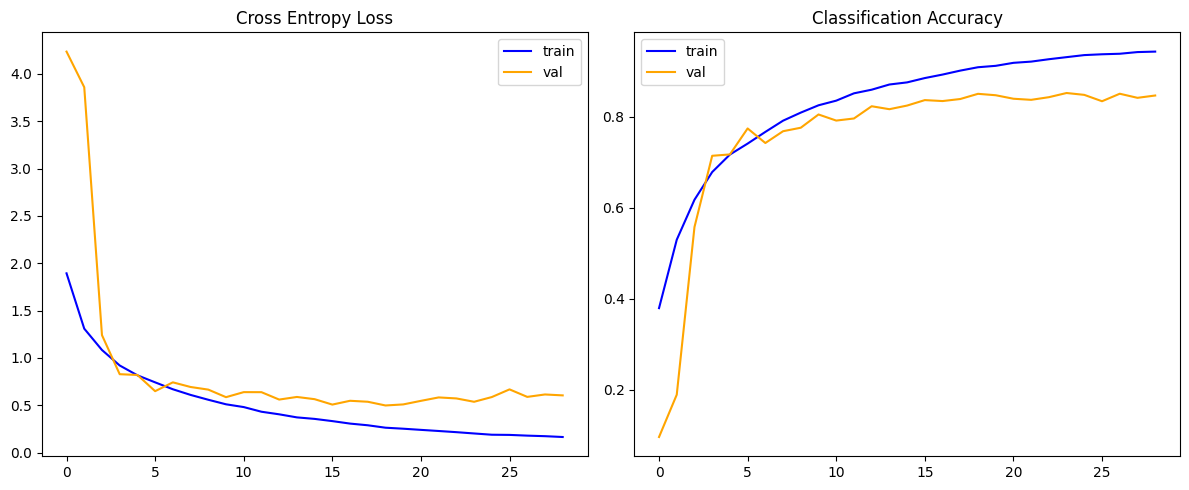

313/313 [==============================] - 1s 3ms/step


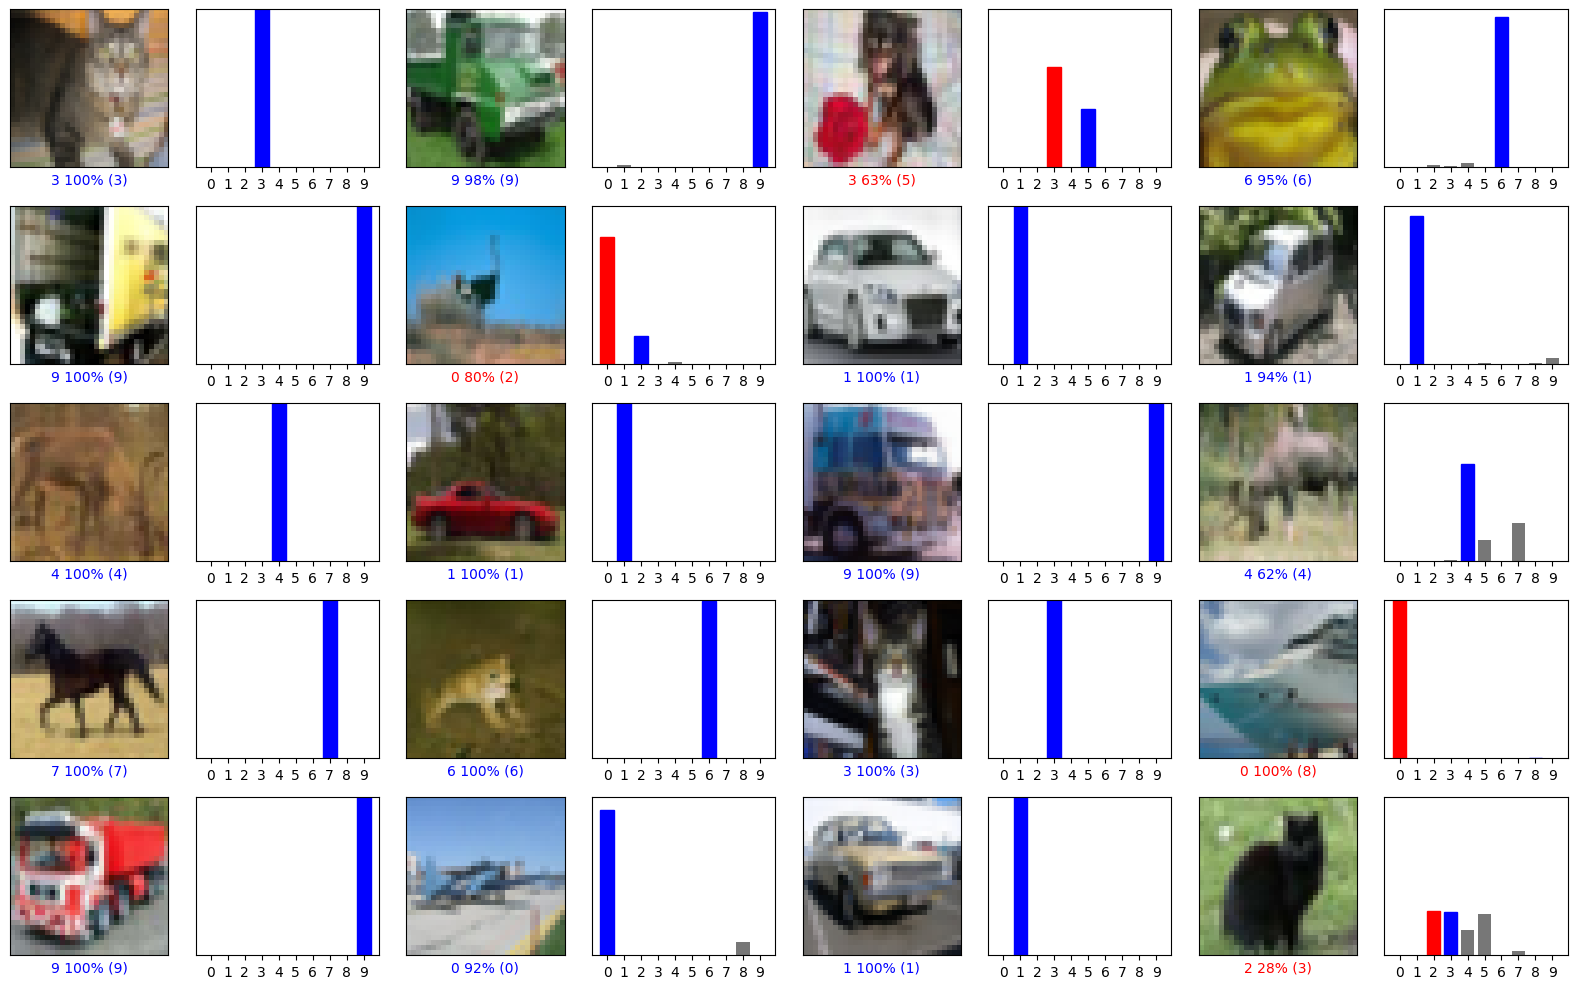


 Training time: 0:06:29.096297

 Train accuracy: 0.965

 Test accuracy: 0.845
Batch size 224: Test accuracy 0.845


In [ ]:
"""
batch_sizes = [64, 128, 256] #256 was the best one
batch_sizes = [160, 192, 224]

for bs in batch_sizes:
    model = model = ks.Sequential([
    # Convolutional Block 1
    ks.layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    ks.layers.BatchNormalization(),
    ks.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    ks.layers.BatchNormalization(),
    ks.layers.MaxPooling2D((2, 2)),
    ks.layers.Dropout(0.2),

    # Convolutional Block 2
    ks.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    ks.layers.BatchNormalization(),
    ks.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    ks.layers.BatchNormalization(),
    ks.layers.MaxPooling2D((2, 2)),
    ks.layers.Dropout(0.3),

    # Convolutional Block 3
    ks.layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    ks.layers.BatchNormalization(),
    ks.layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    ks.layers.BatchNormalization(),
    ks.layers.MaxPooling2D((2, 2)),
    ks.layers.Dropout(0.4),

    # Fully Connected Layers
    ks.layers.Flatten(),
    ks.layers.Dense(512, activation='relu'),
    ks.layers.Dropout(0.5),
    ks.layers.Dense(10, activation='softmax')
    ])

    tester = CIFAR10ModelTester(x_train = x_train_scaled, y_train = y_train,
                            x_val = x_val_scaled, y_val = y_val,
                            x_test = x_test_scaled, y_test = y_test)

    _, _, model_info = tester.test_model(model, epochs=epochs, callbacks=callbacks, model_nr=bs, batch_size=bs)

    print(f"Batch size {bs}: Test accuracy {model_info['Test_Accuracy']}")
    """

## Model 6

Adding:

- **Batch size:** = 256. Best config in previous test.

Model metrics:

**Test accuracy: 0.842**

Epoch 1/75
157/157 [==============================] - 18s 84ms/step - loss: 2.0004 - accuracy: 0.3585 - val_loss: 4.2236 - val_accuracy: 0.0952
Epoch 2/75
157/157 [==============================] - 12s 79ms/step - loss: 1.3425 - accuracy: 0.5189 - val_loss: 3.2007 - val_accuracy: 0.1435
Epoch 3/75
157/157 [==============================] - 12s 79ms/step - loss: 1.1383 - accuracy: 0.5970 - val_loss: 2.0261 - val_accuracy: 0.3452
Epoch 4/75
157/157 [==============================] - 13s 80ms/step - loss: 0.9679 - accuracy: 0.6602 - val_loss: 0.9987 - val_accuracy: 0.6530
Epoch 5/75
157/157 [==============================] - 13s 80ms/step - loss: 0.8531 - accuracy: 0.7038 - val_loss: 0.8077 - val_accuracy: 0.7154
Epoch 6/75
157/157 [==============================] - 12s 80ms/step - loss: 0.7545 - accuracy: 0.7382 - val_loss: 0.6863 - val_accuracy: 0.7639
Epoch 7/75
157/157 [==============================] - 12s 79ms/step - loss: 0.6895 - accuracy: 0.7609 - val_loss: 0.8783 - val_accuracy:

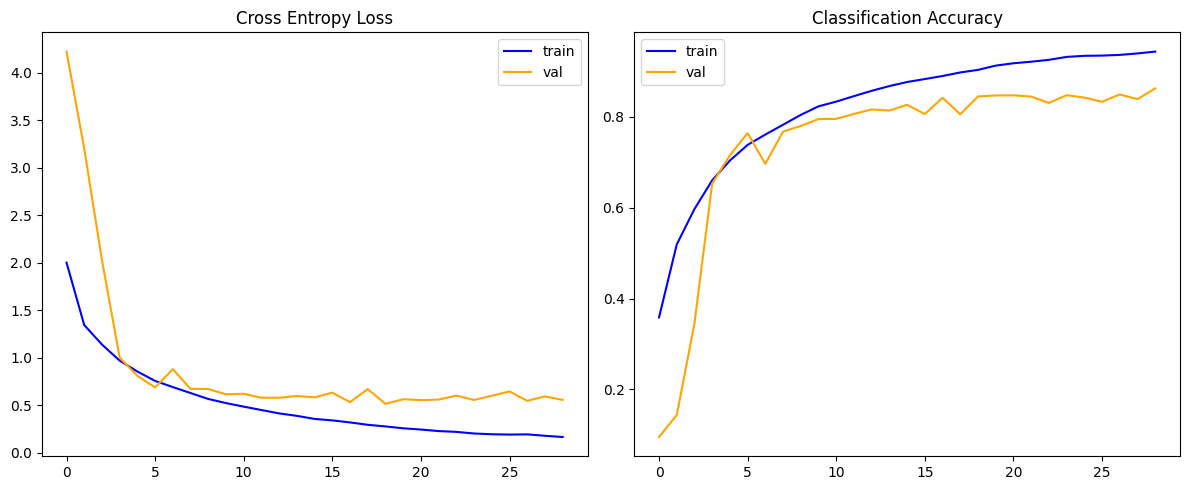

313/313 [==============================] - 1s 3ms/step


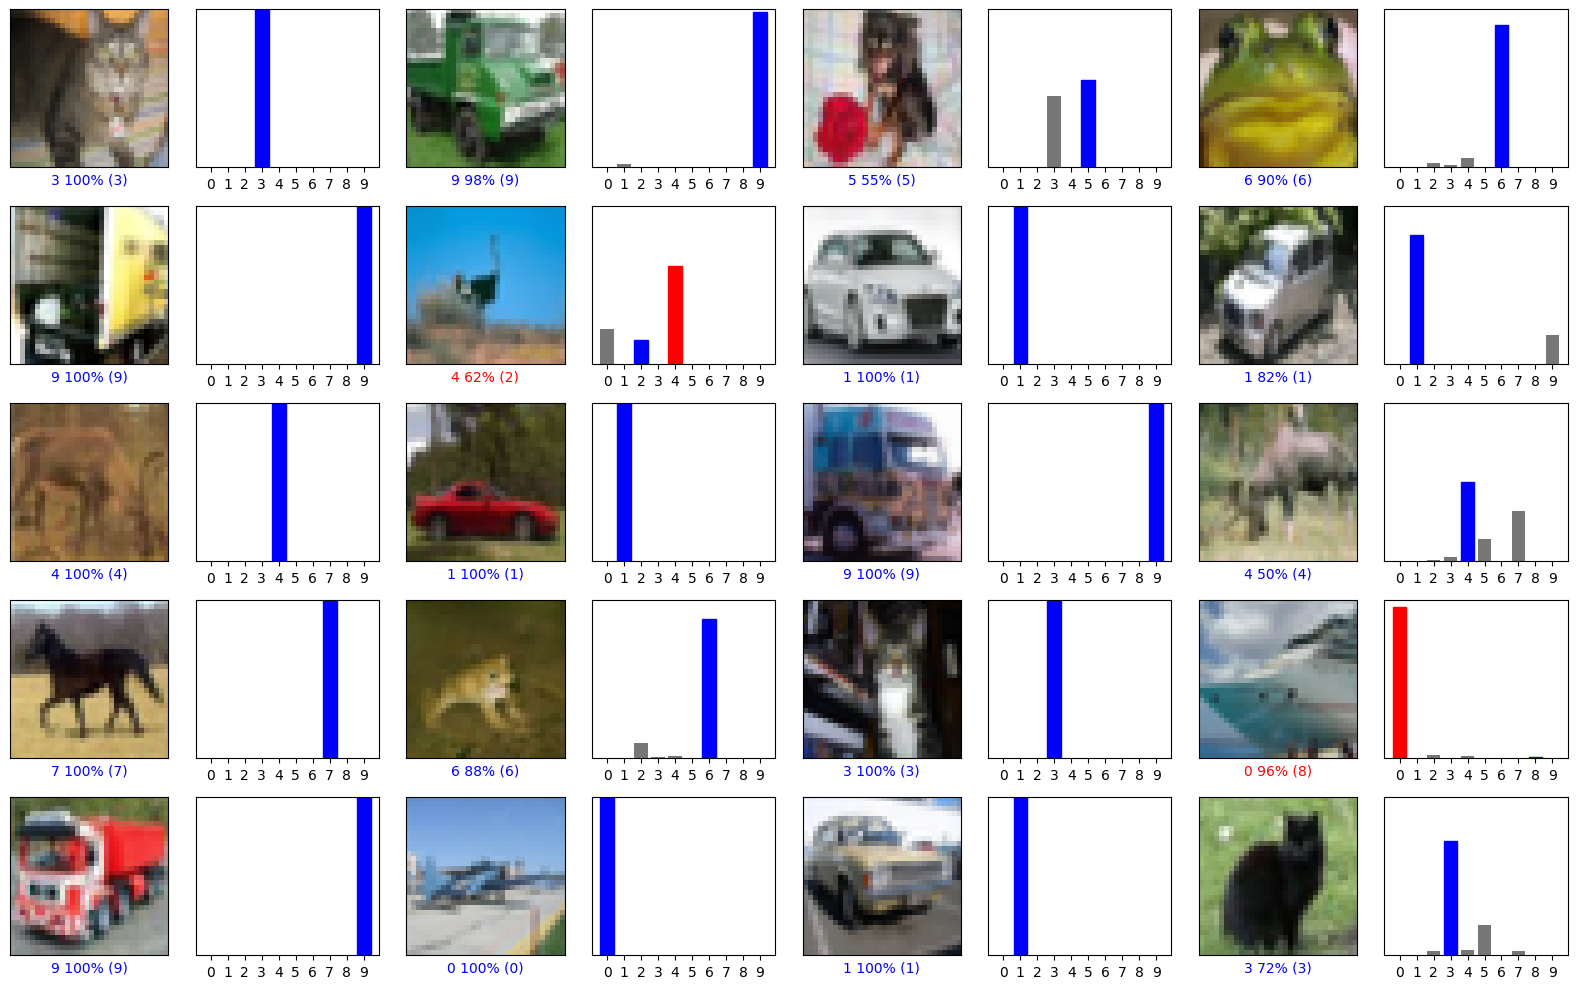


 Training time: 0:06:11.203530

 Train accuracy: 0.964

 Test accuracy: 0.842


In [ ]:
model_nr = 6
epochs = 75
batch_size = 256

model = model = ks.Sequential([
    # Convolutional Block 1
    ks.layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    ks.layers.BatchNormalization(),
    ks.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    ks.layers.BatchNormalization(),
    ks.layers.MaxPooling2D((2, 2)),
    ks.layers.Dropout(0.2),

    # Convolutional Block 2
    ks.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    ks.layers.BatchNormalization(),
    ks.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    ks.layers.BatchNormalization(),
    ks.layers.MaxPooling2D((2, 2)),
    ks.layers.Dropout(0.3),

    # Convolutional Block 3
    ks.layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    ks.layers.BatchNormalization(),
    ks.layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    ks.layers.BatchNormalization(),
    ks.layers.MaxPooling2D((2, 2)),
    ks.layers.Dropout(0.4),

    # Fully Connected Layers
    ks.layers.Flatten(),
    ks.layers.Dense(512, activation='relu'),
    ks.layers.Dropout(0.5),
    ks.layers.Dense(10, activation='softmax')
    ])

# Model loading with prepared data
tester = CIFAR10ModelTester(x_train = x_train_scaled, y_train = y_train,
                            x_val = x_val_scaled, y_val = y_val,
                            x_test = x_test_scaled, y_test = y_test)

# Model testing
model, history, model_info = tester.test_model(model, model_nr=model_nr,
                                               epochs=epochs, callbacks=callbacks,
                                               batch_size=batch_size)

In [ ]:
#merge model_info with dataframe
model_info_df = pd.DataFrame.from_dict(model_info, orient='index').T # convert dictionary to dataframe and transpose
model_info_df.set_index('Model_nr', inplace=True)

models_compare_df = models_compare_df.merge(model_info_df, how='outer')

# Model and stats saving
model.save(path+f'cifar10_model_{model_nr}.h5')
models_compare_df.to_csv(path+'models_compare_df.csv')

print('\n', models_compare_df)

## Model 7 (best without advanced techniques)

Added:
- **Regularization: weight decay:** Train and val loss and accuracy curves are getting further apart. Adding weight decay as a regularization technique helps prevent overfitting by penalizing large weights during training
- **Learning rate scheduler:** Added a ReduceLROnPlateau callback to dynamically adjust the learning rate during training.
- **Model checkpointing:** Did not improve model before but bibliography says its a good practice. Added to save the best model during training.
- **Slight adjustment to optimizer:** Lowered the initial learning rate of Adam to 0.001 for potentially better convergence.

I also tested **Global Average Pooling** instead of Flatten. Found in paper applied to cifar10.

### Model metrics:

**GlobalAveragePooling2D Test accuracy: 0.894**

**Flatten Test accuracy: 0.887**

In [ ]:
model = ks.Sequential([
    # Convolutional Block 1
    ks.layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=ks.regularizers.l2(0.01), input_shape=(32, 32, 3)),
    ks.layers.BatchNormalization(),
    ks.layers.Activation('relu'),
    ks.layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=ks.regularizers.l2(0.01)),
    ks.layers.BatchNormalization(),
    ks.layers.Activation('relu'),
    ks.layers.MaxPooling2D((2, 2)),
    ks.layers.Dropout(0.2),

    # Convolutional Block 2
    ks.layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=ks.regularizers.l2(0.01)),
    ks.layers.BatchNormalization(),
    ks.layers.Activation('relu'),
    ks.layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=ks.regularizers.l2(0.01)),
    ks.layers.BatchNormalization(),
    ks.layers.Activation('relu'),
    ks.layers.MaxPooling2D((2, 2)),
    ks.layers.Dropout(0.3),

    # Convolutional Block 3
    ks.layers.Conv2D(256, (3, 3), padding='same', kernel_regularizer=ks.regularizers.l2(0.01)),
    ks.layers.BatchNormalization(),
    ks.layers.Activation('relu'),
    ks.layers.Conv2D(256, (3, 3), padding='same', kernel_regularizer=ks.regularizers.l2(0.01)),
    ks.layers.BatchNormalization(),
    ks.layers.Activation('relu'),
    ks.layers.MaxPooling2D((2, 2)),
    ks.layers.Dropout(0.4),

    # Global Average Pooling ---> one or the other
    ks.layers.GlobalAveragePooling2D(),
    # Flatten
    #ks.layers.Flatten(),

    # Fully Connected Layers
    ks.layers.Dense(512, activation='relu'),
    ks.layers.Dropout(0.5),
    ks.layers.Dense(10, activation='softmax')
])

Epoch 1/100
156/157 [============================>.] - ETA: 0s - loss: 6.3626 - accuracy: 0.2384
Epoch 1: val_accuracy improved from -inf to 0.09830, saving model to best_model.h5
157/157 [==============================] - 19s 93ms/step - loss: 6.3578 - accuracy: 0.2385 - val_loss: 4.4853 - val_accuracy: 0.0983 - lr: 0.0010
Epoch 2/100
156/157 [============================>.] - ETA: 0s - loss: 2.2996 - accuracy: 0.3871
Epoch 2: val_accuracy improved from 0.09830 to 0.12020, saving model to best_model.h5
157/157 [==============================] - 14s 87ms/step - loss: 2.2986 - accuracy: 0.3871 - val_loss: 3.2861 - val_accuracy: 0.1202 - lr: 0.0010
Epoch 3/100
156/157 [============================>.] - ETA: 0s - loss: 1.7239 - accuracy: 0.4769
Epoch 3: val_accuracy improved from 0.12020 to 0.13970, saving model to best_model.h5
157/157 [==============================] - 14s 90ms/step - loss: 1.7241 - accuracy: 0.4768 - val_loss: 3.3897 - val_accuracy: 0.1397 - lr: 0.0010
Epoch 4/100
156/

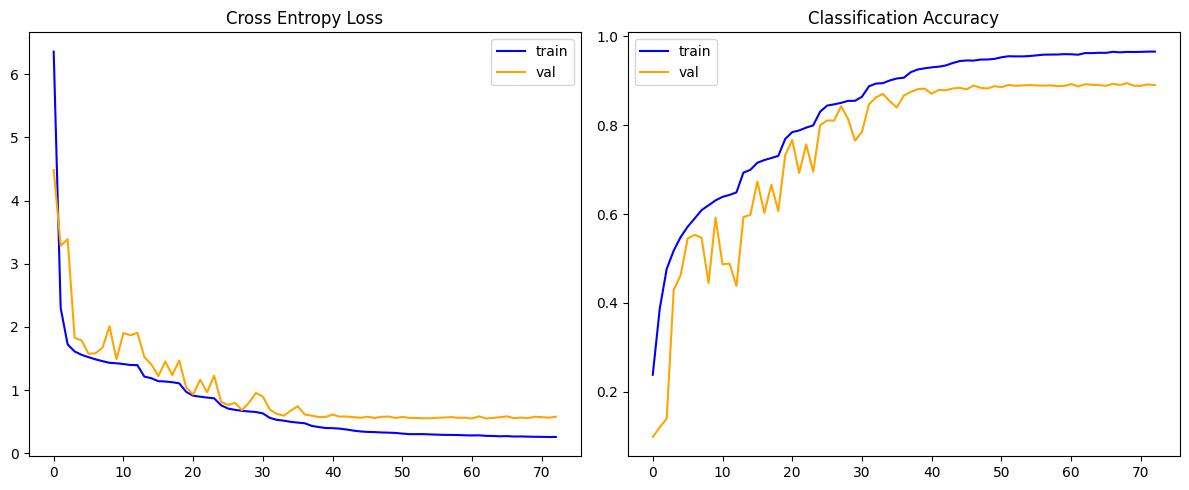

313/313 [==============================] - 1s 3ms/step


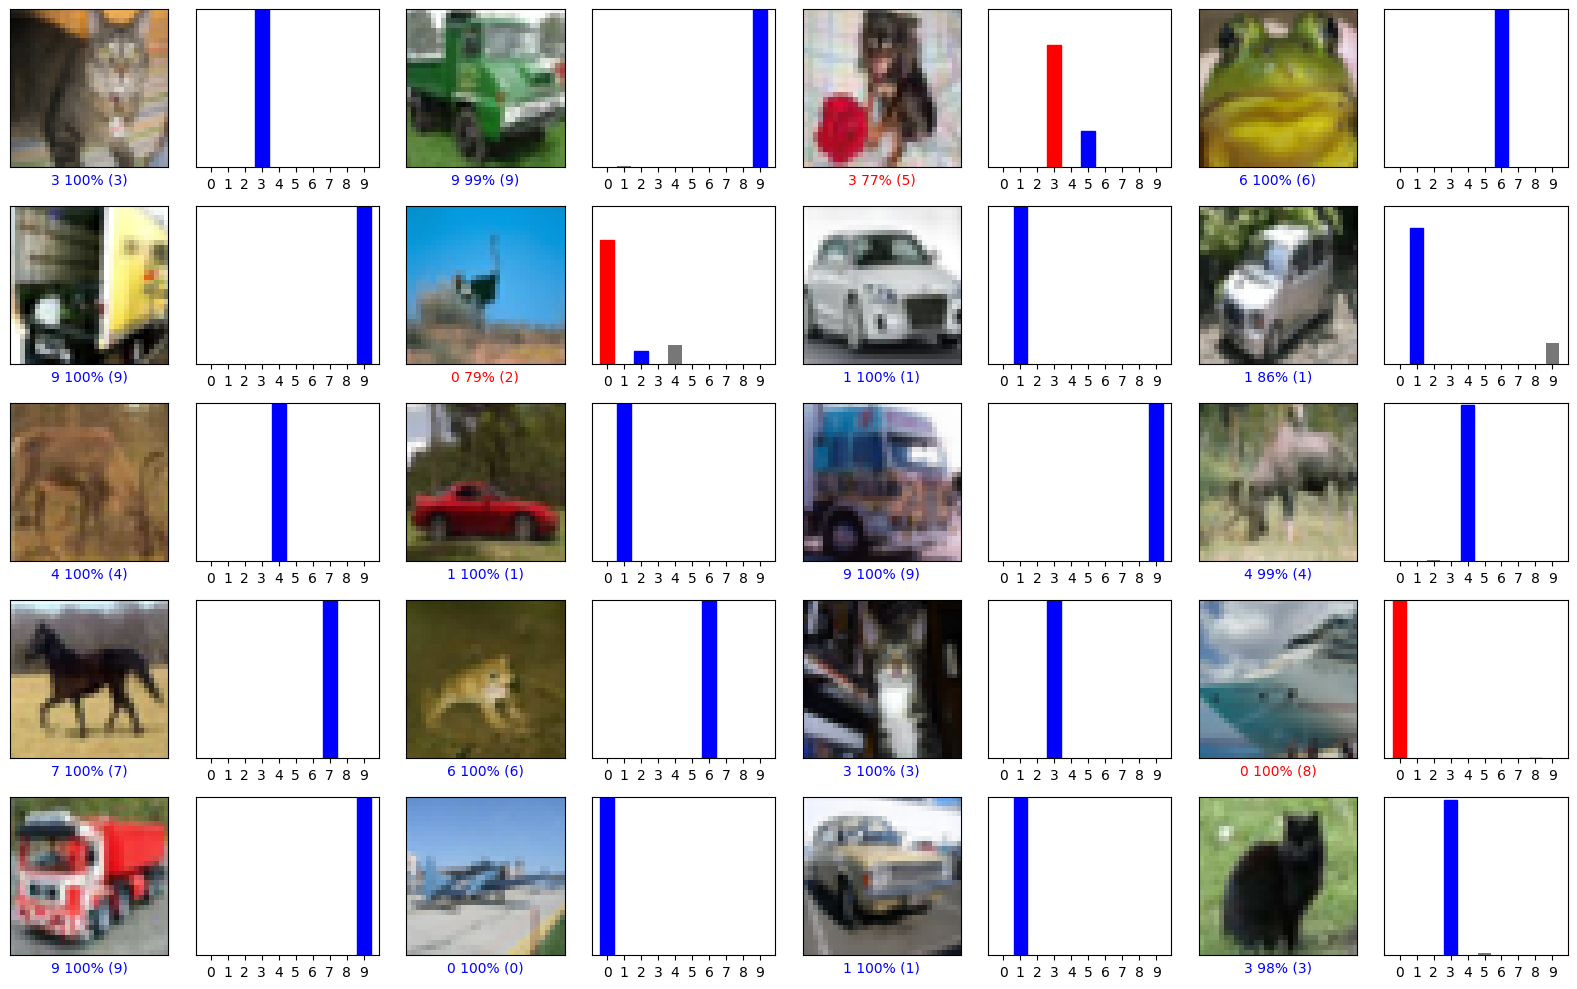


 Training time: 0:17:02.208214

 Train accuracy: 0.997

 Test accuracy: 0.887


In [ ]:
model_nr = 7
epochs = 100
batch_size = 256


optimizer = ks.optimizers.Adam(learning_rate=0.001)

lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
callbacks=[lr_reduction, checkpoint, early_stopping]

# Model loading with prepared data
tester = CIFAR10ModelTester(x_train = x_train_scaled, y_train = y_train,
                            x_val = x_val_scaled, y_val = y_val,
                            x_test = x_test_scaled, y_test = y_test)

# Model testing
model, history, model_info = tester.test_model(model, model_nr=model_nr,
                                               epochs=epochs, callbacks=callbacks, optimizer=optimizer,
                                               batch_size=batch_size)

In [ ]:
#merge model_info with dataframe
model_info_df = pd.DataFrame.from_dict(model_info, orient='index').T # convert dictionary to dataframe and transpose
model_info_df.set_index('Model_nr', inplace=True)

models_compare_df = models_compare_df.merge(model_info_df, how='outer')

# Model and stats saving
model.save(path+f'cifar10_model_{model_nr}.h5')
models_compare_df.to_csv(path+'models_compare_df.csv')

print('\n', models_compare_df)

# Data augmentation




## Model 8 (run in kaggle)

Adding simple **data augmentation:**


Data augmentation artificially expands the dataset by creating variations of existing images, which helps to reduce overfitting and improve the model's ability to generalize to unseen data.

- rotation_range=15: Gira aleatoriamente las imágenes hasta 15 grados en cualquier dirección.
- width_shift_range=0.1: Desplaza las imágenes horizontalmente hasta un 10% del ancho total.
- height_shift_range=0.1: Desplaza las imágenes verticalmente hasta un 10% del alto total.
- horizontal_flip=True: Voltea aleatoriamente las imágenes horizontalmente (como un espejo).
- zoom_range=0.1: Acerca o aleja aleatoriamente las imágenes hasta un 10%.
- fill_mode='nearest': Si al aplicar las transformaciones quedan huecos en los bordes, los rellena con los píxeles más cercanos.

### Model metrics:

**Test accuracy: 0.844** --> **WORSE THAN M7**

In [ ]:
# Reload CIFAR-10 data
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1
x_train_scaled, x_test_scaled = x_train / 255.0, x_test / 255.0

# Flatten labels
y_train = y_train.ravel()
y_test = y_test.ravel()

# CIFAR-10 labels
cifar10_labels = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# Split validation data from training data
x_val_scaled = x_train_scaled[-10000:]
y_val = y_train[-10000:]
x_train_scaled = x_train_scaled[:-10000]
y_train = y_train[:-10000:]

# Define the ImageDataGenerator for basic augmentations
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)

Augmented images:


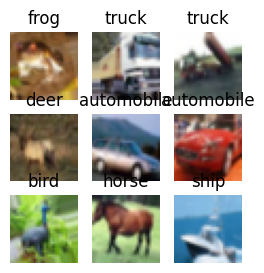

In [ ]:
# Apply augmentations and display augmented images
print('Augmented images:')
plt.figure(figsize=(3, 3))
for x_batch, y_batch in datagen.flow(x_train_scaled[:9], y_train[:9], batch_size=9, shuffle=False):
    for i in range(9):
        plt.subplot(330 + 1 + i)
        plt.imshow(x_batch[i])
        plt.title(cifar10_labels[y_batch[i]])
        plt.axis('off')
    break  # Only visualize one batch of augmented images
plt.show()

In [ ]:
# Fit the datagen to the training data
datagen.fit(x_train_scaled)

# Create generators
batch_size = 256  # Keep your optimal batch size
train_generator = datagen.flow(x_train_scaled, y_train, batch_size=batch_size)

# For validation and test, we'll create generators without augmentation
val_datagen = ImageDataGenerator()  # No augmentation
test_datagen = ImageDataGenerator()  # No augmentation

val_generator = val_datagen.flow(x_val_scaled, y_val, batch_size=batch_size, shuffle=False)
test_generator = test_datagen.flow(x_test_scaled, y_test, batch_size=batch_size, shuffle=False)

# Calculate steps per epoch
steps_per_epoch = len(x_train_scaled) // batch_size
validation_steps = len(x_val_scaled) // batch_size

In [ ]:
# same model 7
model = ks.Sequential([
    # Convolutional Block 1
    ks.layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=ks.regularizers.l2(0.01), input_shape=(32, 32, 3)),
    ks.layers.BatchNormalization(),
    ks.layers.Activation('relu'),
    ks.layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=ks.regularizers.l2(0.01)),
    ks.layers.BatchNormalization(),
    ks.layers.Activation('relu'),
    ks.layers.MaxPooling2D((2, 2)),
    ks.layers.Dropout(0.2),

    # Convolutional Block 2
    ks.layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=ks.regularizers.l2(0.01)),
    ks.layers.BatchNormalization(),
    ks.layers.Activation('relu'),
    ks.layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=ks.regularizers.l2(0.01)),
    ks.layers.BatchNormalization(),
    ks.layers.Activation('relu'),
    ks.layers.MaxPooling2D((2, 2)),
    ks.layers.Dropout(0.3),

    # Convolutional Block 3
    ks.layers.Conv2D(256, (3, 3), padding='same', kernel_regularizer=ks.regularizers.l2(0.01)),
    ks.layers.BatchNormalization(),
    ks.layers.Activation('relu'),
    ks.layers.Conv2D(256, (3, 3), padding='same', kernel_regularizer=ks.regularizers.l2(0.01)),
    ks.layers.BatchNormalization(),
    ks.layers.Activation('relu'),
    ks.layers.MaxPooling2D((2, 2)),
    ks.layers.Dropout(0.4),

    # Global Average Pooling ---> one or the other
    ks.layers.GlobalAveragePooling2D(),
    # Flatten
    #ks.layers.Flatten(),

    # Fully Connected Layers
    ks.layers.Dense(512, activation='relu'),
    ks.layers.Dropout(0.5),
    ks.layers.Dense(10, activation='softmax')
])

In [ ]:
model_nr = 8
epochs = 100

optimizer = ks.optimizers.Adam(learning_rate=0.001)

lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

#if error save weights only:
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
#checkpoint = ModelCheckpoint('best_model.weights.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=True, mode='max', verbose=1)

callbacks=[lr_reduction, checkpoint, early_stopping]


# Create an instance of CIFAR10ModelTester and generators
tester = CIFAR10ModelTester(train_generator=train_generator,
                            val_generator=val_generator,
                            test_generator=test_generator)

# Model testing
model, history, model_info = tester.test_model(model, model_nr=model_nr, epochs=epochs,
                                               callbacks=callbacks, optimizer=optimizer,
                                               batch_size=batch_size, steps_per_epoch=steps_per_epoch,
                                               validation_steps=validation_steps)

Model 8 was Run on kaggle and data appended to models_comparison_df

## Model 8.1 (run in kaggle)

Added **data normalization** to model 8: Incorporated published mean and std values for data normalization, aiming to improve model training and generalization.

**Improved model 8 but not as much as model 7**

Also tested SGD and Adam optimizers:

- Optimizer: Adam, Batch Size: 256, Test Accuracy: 0.8720, Test Loss: 0.5410
- Optimizer: SGD(learning_rate=0.01, momentum=0.9, nesterov=True), Batch Size: 256, Test Accuracy: 0.8546, Test Loss: 0.5984

In [ ]:
import tensorflow as tf
from tensorflow import keras as ks
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

# Load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = ks.datasets.cifar10.load_data()

# Define mean and std for CIFAR-10
mean = np.array([0.491, 0.482, 0.447])
std = np.array([0.246, 0.243, 0.261])

# Normalize pixel values
def custom_normalization(x):
    x = x.astype('float32') / 255.0
    return (x - mean) / std

# Flatten labels
y_train = y_train.ravel()
y_test = y_test.ravel()

# Split validation data from training data
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

# Define the ImageDataGenerator for augmentations
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest',
    preprocessing_function=custom_normalization
)

# Create generators
batch_size = 256
train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)

# For validation and test, we'll create generators without augmentation
val_test_datagen = ImageDataGenerator(preprocessing_function=custom_normalization)
val_generator = val_test_datagen.flow(x_val, y_val, batch_size=batch_size, shuffle=False)
test_generator = val_test_datagen.flow(x_test, y_test, batch_size=batch_size, shuffle=False)

# Calculate steps per epoch
steps_per_epoch = len(x_train) // batch_size
validation_steps = len(x_val) // batch_size

# Define the model
# same model 7
model = ks.Sequential([
    # Convolutional Block 1
    ks.layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=ks.regularizers.l2(0.01), input_shape=(32, 32, 3)),
    ks.layers.BatchNormalization(),
    ks.layers.Activation('relu'),
    ks.layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=ks.regularizers.l2(0.01)),
    ks.layers.BatchNormalization(),
    ks.layers.Activation('relu'),
    ks.layers.MaxPooling2D((2, 2)),
    ks.layers.Dropout(0.2),

    # Convolutional Block 2
    ks.layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=ks.regularizers.l2(0.01)),
    ks.layers.BatchNormalization(),
    ks.layers.Activation('relu'),
    ks.layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=ks.regularizers.l2(0.01)),
    ks.layers.BatchNormalization(),
    ks.layers.Activation('relu'),
    ks.layers.MaxPooling2D((2, 2)),
    ks.layers.Dropout(0.3),

    # Convolutional Block 3
    ks.layers.Conv2D(256, (3, 3), padding='same', kernel_regularizer=ks.regularizers.l2(0.01)),
    ks.layers.BatchNormalization(),
    ks.layers.Activation('relu'),
    ks.layers.Conv2D(256, (3, 3), padding='same', kernel_regularizer=ks.regularizers.l2(0.01)),
    ks.layers.BatchNormalization(),
    ks.layers.Activation('relu'),
    ks.layers.MaxPooling2D((2, 2)),
    ks.layers.Dropout(0.4),

    # Global Average Pooling ---> one or the other
    ks.layers.GlobalAveragePooling2D(),
    # Flatten
    #ks.layers.Flatten(),

    # Fully Connected Layers
    ks.layers.Dense(512, activation='relu'),
    ks.layers.Dropout(0.5),
    ks.layers.Dense(10, activation='softmax')
])

In [ ]:
model_nr = 8.1
epochs = 200

optimizer = ks.optimizers.Adam(learning_rate=0.001)

lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.7, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)

#if error save weights only:
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
#checkpoint = ModelCheckpoint('best_model.weights.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=True, mode='max', verbose=1)

callbacks=[lr_reduction, checkpoint, early_stopping]


# Create an instance of CIFAR10ModelTester and generators
tester = CIFAR10ModelTester(train_generator=train_generator,
                            val_generator=val_generator,
                            test_generator=test_generator)

# Model testing
model, history, model_info = tester.test_model(model, model_nr=model_nr, epochs=epochs,
                                               callbacks=callbacks, optimizer=optimizer,
                                               batch_size=batch_size, steps_per_epoch=steps_per_epoch,
                                               validation_steps=validation_steps)

# Transfer Learning (run in kaggle)

Since model architecture and hyperparameter optimizations plateaued below the desired accuracy threshold (0.9), transfer learning was employed to leverage pre-trained models and their established feature extraction capabilities for improved performance.

In [3]:
# Download all models stats from keras applications
trained_models = pd.read_html("https://keras.io/api/applications/")[0]

In [4]:
trained_models['Parameters_M'] = trained_models['Parameters'].map(lambda x: x[:-1]).astype('float32')

In [10]:
trained_models[trained_models['Top-1 Accuracy'] >= '79'].sort_values(by = 'Parameters_M').head(10)

,Model,Size (MB),Top-1 Accuracy,Top-5 Accuracy,Parameters,Depth,Time (ms) per inference step (CPU),Time (ms) per inference step (GPU),Parameters_M
19,EfficientNetB1,31.00,79.1%,94.4%,7.9M,186,60.2,5.6,7.9
27,EfficientNetV2B1,34.00,79.8%,95.0%,8.2M,-,-,-,8.2
20,EfficientNetB2,36.00,80.1%,94.9%,9.2M,186,80.8,6.5,9.2
28,EfficientNetV2B2,42.00,80.5%,95.1%,10.2M,-,-,-,10.2
21,EfficientNetB3,48.00,81.6%,95.7%,12.3M,210,140.0,8.8,12.3
29,EfficientNetV2B3,59.00,82.0%,95.8%,14.5M,-,-,-,14.5
22,EfficientNetB4,75.00,82.9%,96.4%,19.5M,258,308.3,15.1,19.5
30,EfficientNetV2S,88.00,83.9%,96.7%,21.6M,-,-,-,21.6
0,Xception,88.00,79.0%,94.5%,22.9M,81,109.4,8.1,22.9
33,ConvNeXtTiny,109.42,81.3%,-,28.6M,-,-,-,28.6


# Xception vs EfficientNetB2

Xception and EfficientNetB2 were initially chosen for their competitive accuracy on ImageNet and relatively efficient architectures.

Xception boasts a top-1 accuracy of 79%, comparable to larger models, while maintaining a moderate parameter count of 22.9M.

EfficientNetB2, known for its scalability, offers 80.1% top-1 accuracy with a slightly larger parameter count of 9.2M, still significantly smaller than many other high-performing architectures.

### **Xception** (model 9)

The Xception model implementation followed the Keras documentation's transfer learning guidelines, freezing then unfreezing all layers for optimal learning.

Dropout and global average pooling were also added.

Despite testing various data augmentation techniques (including Keras' ImageDataGenerator and a custom cifarpolicy obtained from https://github.com/DeepVoltaire/AutoAugment), no significant improvement was seen on non-augmented data.

#### **Test accuracy: 0.9365**

In [ ]:
from tensorflow import keras

# Load CIFAR-10 data
cifar10 = keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1
x_train_scaled, x_test_scaled = x_train / 255.0, x_test / 255.0

# Flatten labels
y_train = y_train.ravel()
y_test = y_test.ravel()

# Split validation data from training data
x_val_scaled = x_train_scaled[-10000:]
y_val = y_train[-10000:]
x_train_scaled = x_train_scaled[:-10000]
y_train = y_train[:-10000]

# Define the base model with Xception, without the top layer, using imagenet weights
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

# Freeze the base model
base_model.trainable = False

# Create a new model on top of the base model
inputs = keras.Input(shape=(32, 32, 3))
# Resize images from CIFAR-10 to the input size expected by Xception (150x150)
x = layers.Resizing(150, 150)(inputs)
# Make sure the base_model is running in inference mode
x = base_model(x, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout

# A Dense classifier with 10 units for the 10 CIFAR-10 classes
outputs = layers.Dense(10)(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

# First phase of training: train only the top layers
model.fit(x_train_scaled, y_train, epochs=20,
          validation_data=(x_val_scaled, y_val))

# Unfreeze the base model
base_model.trainable = True
model.summary(show_trainable=True)

# It's important to recompile your model after changing the trainable attribute
model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

# Second phase of training: fine-tune the entire model
model.fit(x_train_scaled, y_train, epochs=10,
          validation_data=(x_val_scaled, y_val))

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(x_test_scaled, y_test)
print(f'Test accuracy: {test_accuracy:.4f}')

### **EfficientNetB2** (Model 10)

EfficientNetB2 handles preprocessing internally, simplifying the code.

Again: Data augmentation techniques failed to improve model.

#### **Test accuracy: 0.9588**

In [ ]:
from tensorflow import keras

# Load CIFAR-10 data
cifar10 = keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# For EfficientNet, we keep pixel values in the [0-255] range
# No need to normalize to [0-1]

# Flatten labels
y_train = y_train.ravel()
y_test = y_test.ravel()

# Split validation data from training data
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

# Define the base model with EfficientNetB2, without the top layer, using imagenet weights
base_model = keras.applications.EfficientNetB2(
    weights='imagenet',
    input_shape=(260, 260, 3),
    include_top=False)

# Freeze the base model
base_model.trainable = False

# Create a new model on top of the base model
inputs = keras.Input(shape=(32, 32, 3))
# Resize images from CIFAR-10 to the input size expected by EfficientNetB2 (260x260)
x = layers.Resizing(260, 260)(inputs)
# The EfficientNet model includes preprocessing, so we don't need to add it manually
x = base_model(x, training=False)
# Convert features to vectors
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)  # Regularize with dropout
# A Dense classifier with 10 units for the 10 CIFAR-10 classes
outputs = layers.Dense(10)(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

# First phase of training: train only the top layers
model.fit(x_train, y_train, epochs=20,
          validation_data=(x_val, y_val))

# Unfreeze the base model
base_model.trainable = True

""" Fine-tune from this layer onwards
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False"""

model.summary(show_trainable=True)

# It's important to recompile your model after changing the trainable attribute
model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

# Second phase of training: fine-tune the model
model.fit(x_train, y_train, epochs=10,
          validation_data=(x_val, y_val))

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_accuracy:.4f}')

# ResNet34 (from fast.ai)

In just a few lines, this FastAI code accomplishes a lot:

- Downloads the CIFAR-10 dataset.
- ImageDataLoaders or Datablocks effortlessly creates data loaders for training and validation, applying image resizing, transformations, and normalization.
- vision_learner builds a pretrained ResNet34 model.
- lr_find automatically finds the optimal learning rate.
- fine_tune trains the model in two phases: first, with frozen pre-trained layers, and then with all layers unfrozen.

#### **Final accuracy in validation data: 0.9717**

In [ ]:
from fastai.vision.all import *

In [ ]:
# Set up path and data
path = untar_data(URLs.CIFAR)
dls = ImageDataLoaders.from_folder(path, valid='test', item_tfms=Resize(224),
                                   batch_tfms=[*aug_transforms(size=224, min_scale=0.75),
                                               Normalize.from_stats(*imagenet_stats)])

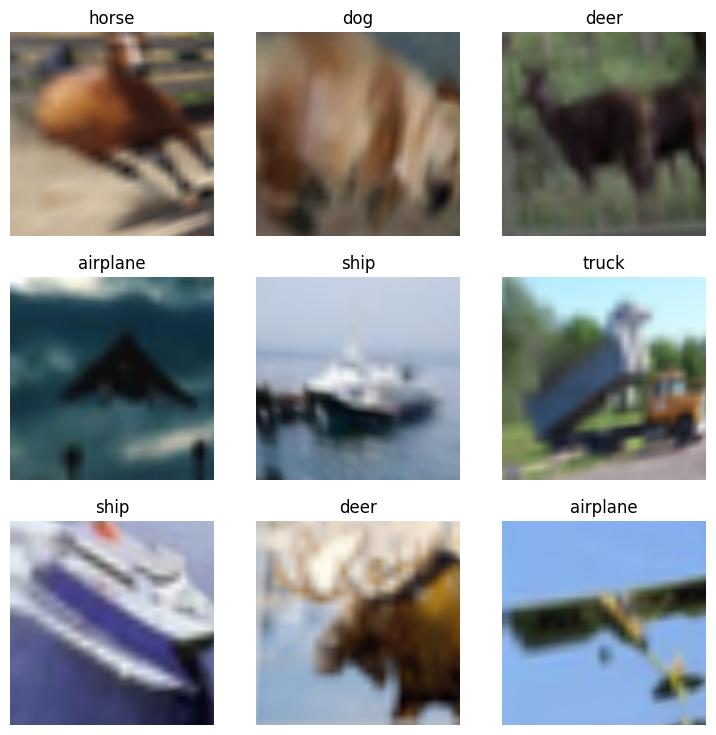

In [ ]:
dls.show_batch()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 127MB/s]


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.611870,0.382106,0.130800,0.869200,04:05


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.316924,0.233842,0.079500,0.920500,05:11
1,0.225996,0.173130,0.058800,0.941200,05:11
2,0.131369,0.126769,0.043500,0.956500,05:10
3,0.072970,0.114528,0.036500,0.963500,05:10


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.058107,0.109318,0.035700,0.964300,05:11
1,0.055517,0.116734,0.037200,0.962800,05:11
2,0.049367,0.119017,0.036100,0.963900,05:11
3,0.041663,0.112830,0.035400,0.964600,05:09
4,0.038841,0.114028,0.035300,0.964700,05:10


Final accuracy: 0.9717


Path('/root/.fastai/data/cifar10/models/final_model.pth')

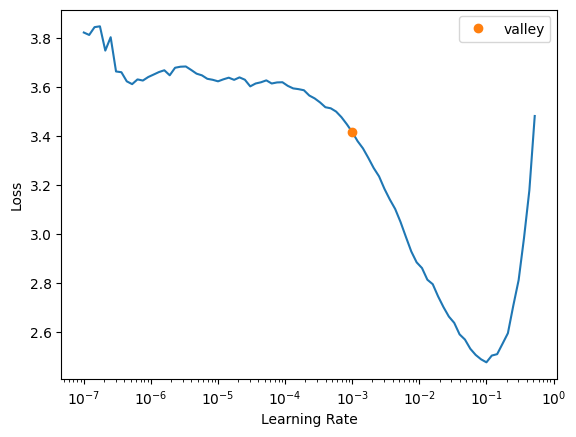

In [ ]:
# Create learner
learn = vision_learner(dls, resnet34, metrics=[error_rate, accuracy])

# Find learning rate
learn.lr_find()

# Fine-tune
learn.fine_tune(4, freeze_epochs=1)

# Unfreeze and train with discriminative learning rates
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-6, 1e-4))

# Test Time Augmentation
preds, targs = learn.tta()
print(f"Final accuracy: {accuracy(preds, targs).item():.4f}")

# Save the model
learn.save('final_model')

### Custom train, val, test split (run in kaggle) (Model 11)

The CIFAR-10 dataset, in its standard format, is divided into 'train' and 'test' folders.

FastAI's native ImageDataLoaders and DataBlocks, which are typically used to load such data, directly splits the data into training and validation sets.

This lacks the flexibility to create a separate test set (unseen for the model) from the original training data.

To address this, custom code was implemented to create a dedicated test set from the original training data. This involved shuffling the images, reserving 10,000 for test, and organizing them into temporary directories for model training and evaluation using FastAI's DataBlock.

#### Final Results:

- Validation final accuracy: 0.9675

- Evaluation accuracy on all evaluation samples: 0.9600

- **Evaluation accuracy with TTA: 0.9706**

In [ ]:
from fastai.vision.all import *
import numpy as np
import shutil
from pathlib import Path

def setup_cifar_files(path, reserved_size=10000):
    # Get all training images
    train_path = path/'train'
    train_files = get_image_files(train_path)

    # Shuffle the files
    np.random.seed(42)  # for reproducibility
    np.random.shuffle(train_files)

    # Extract reserved set
    reserved_files = train_files[:reserved_size]
    new_train_files = train_files[reserved_size:]

    # Create temporary directories
    temp_dir = Path('temp_cifar')
    temp_train_dir = temp_dir/'train'
    temp_test_dir = temp_dir/'test'
    temp_train_dir.mkdir(parents=True, exist_ok=True)
    temp_test_dir.mkdir(parents=True, exist_ok=True)

    # Copy new train files to temporary train directory with subdirectories
    for file in new_train_files:
        class_dir = file.parent.name
        dest_dir = temp_train_dir/class_dir
        dest_dir.mkdir(parents=True, exist_ok=True)
        shutil.copy(file, dest_dir/file.name)

    # Copy test files to temporary test directory with subdirectories
    test_path = path/'test'
    for file in get_image_files(test_path):
        class_dir = file.parent.name
        dest_dir = temp_test_dir/class_dir
        dest_dir.mkdir(parents=True, exist_ok=True)
        shutil.copy(file, dest_dir/file.name)

    return temp_dir, reserved_files

path = untar_data(URLs.CIFAR)
temp_dir, reserved_files = setup_cifar_files(path)

# Get the subdirectories (folders) within the path
folders = [f for f in temp_dir.iterdir() if f.is_dir()]
for folder in folders:
    print(folder)

from fastai.data.external import untar_data, URLs
from fastai.vision.all import *

def count_files_recursive(path):
    """Recursively counts the number of files in a directory and its subdirectories."""
    count = 0
    for item in path.iterdir():
        if item.is_dir():
            count += count_files_recursive(item)
        else:
            count += 1
    return count

# Download the CIFAR dataset if you haven't already
path = temp_dir

# Get the 'train' and 'test' directories
train_path = path / "train"
test_path = path / "test"

# Count files recursively or directly based on directory content
train_count = count_files_recursive(train_path) if any(p.is_dir() for p in train_path.iterdir()) else len(list(train_path.iterdir()))
test_count = count_files_recursive(test_path) if any(p.is_dir() for p in test_path.iterdir()) else len(list(test_path.iterdir()))

print(f"Number of files in train: {train_count}")
print(f"Number of files in test: {test_count}")

path = Path('temp_cifar')

# Define the DataBlock
cifar_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),  # Define the types of input and output
    get_items=get_image_files,           # Function to get image files
    splitter=GrandparentSplitter(train_name='train', valid_name='test'),  # Splitter to create train/valid sets
    get_y=parent_label,                  # Function to get labels from parent folder names
    item_tfms=Resize(224),
    batch_tfms=[*aug_transforms(size=224, min_scale=0.75),
       Normalize.from_stats(*imagenet_stats)]       # Transformation to apply to each item
    )

dls = cifar_block.dataloaders(path, bs=64)  # Adjust batch size (bs) as needed

print(f"Number of training samples: {len(dls.train_ds)}")
print(f"Number of validation samples: {len(dls.valid_ds)}")

"""
temp_cifar/train
temp_cifar/test
Number of files in train: 40000
Number of files in test: 10000
Number of training samples: 40000
Number of validation samples: 10000
"""

In [ ]:
dls.show_batch()

# Create learner
learn = vision_learner(dls, resnet34, metrics=[error_rate, accuracy])

# Find learning rate
learn.lr_find()

# Fine-tune
learn.fine_tune(4, freeze_epochs=1)

# Unfreeze and train with discriminative learning rates
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-6, 1e-4))

# Test Time Augmentation
preds, targs = learn.tta()
print(f"Final accuracy: {accuracy(preds, targs).item():.4f}")

# Save the model
learn.save('final_model')

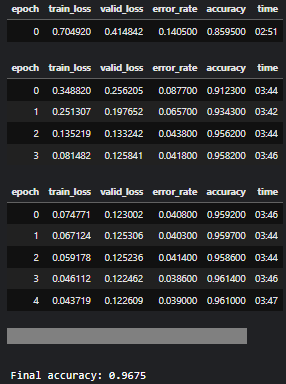

In [ ]:
# Function to set up the evaluation directory with reserved samples
def setup_reserved_eval_dir(reserved_files, eval_dir):
    eval_dir.mkdir(parents=True, exist_ok=True)
    for file in reserved_files:
        class_dir = file.parent.name
        dest_dir = eval_dir/class_dir
        dest_dir.mkdir(parents=True, exist_ok=True)
        shutil.copy(file, dest_dir/file.name)

# Create the evaluation directory
eval_dir = Path('temp_cifar_eval')
setup_reserved_eval_dir(reserved_files, eval_dir)

# Assuming eval_dir is already set up with reserved samples
eval_dir = Path('temp_cifar_eval')

#custom splitter to NOT split data
def nosplit(o):
    return L(int(i) for i in range(len(o))), L()

# Define the DataBlock for evaluation
cifar_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),   # Define the types of input and output
    get_items=get_image_files,            # Function to get image files
    get_y=parent_label,                   # Function to get labels from parent folder names
    item_tfms=Resize(224),
    batch_tfms=[*aug_transforms(size=224, min_scale=0.75),
       Normalize.from_stats(*imagenet_stats)],
    splitter=nosplit
)

# Create DataLoader for evaluation set
eval_dls = cifar_block.dataloaders(eval_dir, bs=64, shuffle_train=False, drop_last=False)

len(eval_dls.train_ds), len(eval_dls.valid_ds) #test set in this case remains inside dls.train
#(10000, 0)

In [ ]:
# Load the saved model
#learn = load_learner('final_model')  # Replace with the path to your saved model folder

# Evaluate on all samples
eval_preds, eval_targs = learn.get_preds(dl=eval_dls.train)
eval_accuracy = accuracy(eval_preds, eval_targs).item()
print(f"Evaluation accuracy on all evaluation samples: {eval_accuracy:.4f}")

Evaluation accuracy on all evaluation samples: 0.9600


In [ ]:
# Using test time augmentation
preds, targs = learn.tta(dl=eval_dls.train)

# Calculate accuracy
accuracy_score = accuracy(preds, targs).item()
print(f"Evaluation accuracy with TTA: {accuracy_score:.4f}")

Evaluation accuracy with TTA: 0.9706


Similar but a slightly lower accuracy was obtained using:

learn = vision_learner(dls, resnet50, metrics=[error_rate, accuracy])
